In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped

discrete_actions = False

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 0.01

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale,lr):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/population_out_size
        ex = math.ceil(ex**(1/(i+1)))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,lr[p],device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,max_seq_length,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_explore_all = []
    gen_exploit_all = []
    a_gen_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r,_ = dis(real_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = torch.mean(torch.pow((dis_out_r[...,0]-rank),2))
            dis_error_real.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.abs(dis_out_r[...,1]-dis_error_real.detach()))
            dis_error_real.backward()
            
            dis_optimizer.step() 
            

        for i in range(len(population)//batch_size):
            #generate children from population
            mutation = torch.from_numpy(np.random.uniform(0,all_a,batch_size)).type('torch.FloatTensor').to(device)
            child,a_gen = gen_children(population,device,gen,batch_size,a = mutation)
            a_gen = torch.mean(torch.abs(a_gen))
            #print("A gen : {}".format(torch.mean(a_gen)))
            #train discriminator
            dis_out_f,dis_out_last = dis(child)
            dis_out_f = dis_out_f.squeeze(-1)
            
            gen_optimizer.zero_grad()
            
            #define generator loss
            variety = -torch.std(dis_out_f[...,0])-torch.mean(torch.std(dis_out_last,-1))
            
            gen_error_exploration =  (variety)-torch.mean(dis_out_f[...,1])#+ a_gen
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) #+ torch.mean(a_gen)
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            gen.hidden = None
            #keep losses to draw graph 
            a_gen_all.append(a_gen)
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            dis_loss_all.append(dis_error_real)  
            dis_confidence_all.append(dis_confidence)
    print(rank)
    print(dis_out_r[...,0])
    #print(get_params(population[0]))
    #print()
            
    return gen_explore_all,gen_exploit_all, dis_loss_all,a_gen_all,dis_confidence_all


starting training
740
Measured population fitness : 3s
population fitness : [ -41.26522659  -93.7667842   -28.3516923   -94.12174845  -98.43043507
  -39.41337039 -112.26838084  -93.24910946  -96.9918838   -96.24158696]
mean fit : -79.41002180624608
tensor([-0.3916,  0.4766, -0.1753, -0.2267,  0.6084, -0.2095, -0.1649, -0.1711,
        -0.2006,  0.4546], device='cuda:0')
tensor([ 0.0046,  0.0012,  0.0037,  0.0029, -0.0022, -0.0088, -0.0067, -0.0037,
         0.0104,  0.0048], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 5s
Evolved : 0s


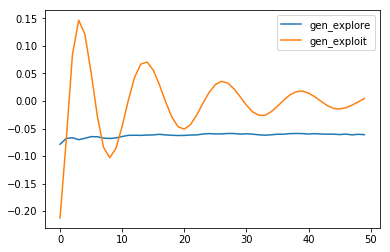

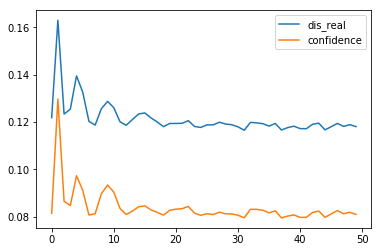

Generation 1  fitness : -28.351692302707498
#################################
Measured population fitness : 2s
population fitness : [-117.41786092  -94.16544074  -93.23727982  -34.40851588  -95.96629458
  -42.59472837 -112.68403241 -112.2037909   -94.54152527  -93.49747749]
mean fit : -89.07169463799679
tensor([-0.1114, -0.1109, -0.1593, -0.1432, -0.1316, -0.3147,  0.4825,  0.6275,
        -0.1010, -0.3193,  0.5595, -0.1039,  0.4676, -0.1070,  0.5033, -0.1157,
        -0.3725, -0.3140, -0.1011, -0.1347], device='cuda:0')
tensor([ 0.0185, -0.0036,  0.0015,  0.0011, -0.0059,  0.0102, -0.0141, -0.0002,
         0.0115, -0.0038, -0.0204,  0.0133,  0.0018, -0.0060, -0.0161, -0.0167,
        -0.0121, -0.0031,  0.0029, -0.0085],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


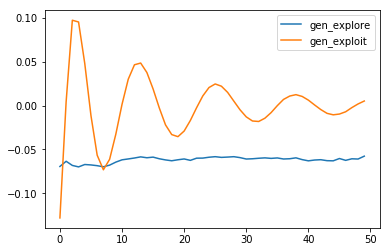

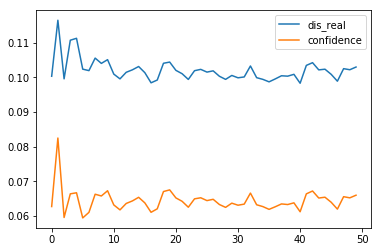

Generation 2  fitness : -34.408515882987956
#################################
Measured population fitness : 5s
population fitness : [ -55.0507061   -92.3229473   -49.41198523 -101.08426325  -35.47360879
  -94.6044926   -94.41757728  -59.26376363  -93.83702412  -27.74429952]
mean fit : -70.32106678060377
tensor([ 0.2268, -0.1588, -0.1550, -0.3636, -0.2396,  0.4921,  0.5783, -0.1624,
        -0.1521,  0.4127,  0.2738,  0.3367, -0.3689, -0.4217, -0.1666, -0.1652,
        -0.1673,  0.5040, -0.1825, -0.1419], device='cuda:0')
tensor([-0.0093, -0.0044, -0.0020, -0.0134, -0.0075, -0.0112, -0.0040, -0.0033,
         0.0019, -0.0037, -0.0176, -0.0035, -0.0017, -0.0155, -0.0124, -0.0114,
        -0.0065,  0.0036, -0.0016, -0.0019],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


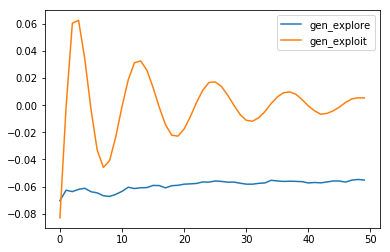

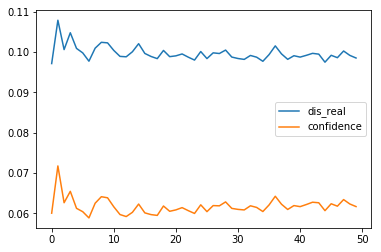

Generation 3  fitness : -27.74429951715531
#################################
Measured population fitness : 3s
population fitness : [ -39.61869608  -95.44797028 -114.01747877  -26.01069473 -119.42019684
  -94.0933899  -112.67587123 -113.42795706  -94.44892532  -27.98460211]
mean fit : -83.71457823135758
tensor([-0.1586,  0.4834, -0.3574,  0.2287, -0.2190, -0.1496, -0.1441,  0.3342,
        -0.3511, -0.3431, -0.4153, -0.1479,  0.5662,  0.2738, -0.1476,  0.5847,
        -0.1252, -0.1414,  0.5636,  0.4390], device='cuda:0')
tensor([0.0547, 0.0154, 0.0410, 0.0541, 0.0618, 0.0410, 0.0488, 0.0141, 0.0085,
        0.0550, 0.0313, 0.0174, 0.0272, 0.0648, 0.0530, 0.0640, 0.0383, 0.0452,
        0.0189, 0.0547], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


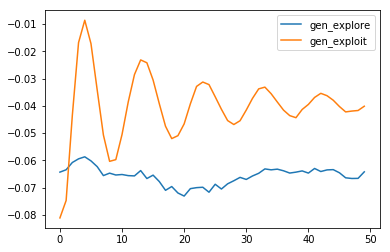

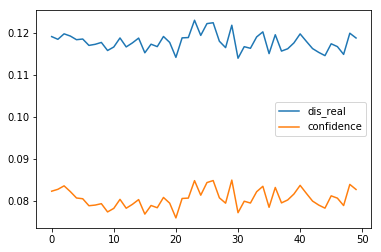

Generation 4  fitness : -26.01069473263606
#################################
Measured population fitness : 6s
population fitness : [ -14.42154868  -99.16772926  -93.04733465  -31.5729232   -34.53838962
  -31.6771913  -113.08174403  -38.8625008   -93.48247123  -37.14692744]
mean fit : -58.69987602100658
tensor([-0.1700, -0.1829, -0.2183,  0.3488, -0.3508, -0.3541, -0.1734, -0.3598,
        -0.4112,  0.4784,  0.4244, -0.1642,  0.3724,  0.4596,  0.5888,  0.3972,
         0.4254, -0.3470,  0.3560, -0.1600], device='cuda:0')
tensor([0.0389, 0.0480, 0.0622, 0.0568, 0.0485, 0.0637, 0.0362, 0.0532, 0.0630,
        0.0485, 0.0446, 0.0611, 0.0511, 0.0624, 0.0362, 0.0582, 0.0503, 0.0483,
        0.0404, 0.0469], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


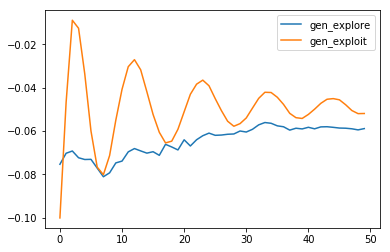

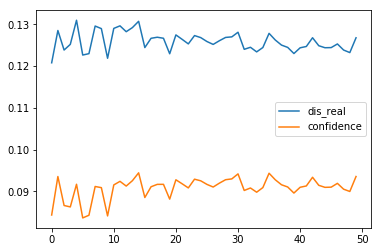

Generation 5  fitness : -14.4215486830596
#################################
Measured population fitness : 6s
population fitness : [-111.57029676  -92.98278168 -118.73304076  -53.70981163  -31.65408039
  -94.75532927  -53.72526973  -47.25651766  -24.5053667    -6.60555245]
mean fit : -63.549804703101756
tensor([-0.3319, -0.1828, -0.2220, -0.3954,  0.3509, -0.1677, -0.1716,  0.5292,
         0.3763,  0.1810, -0.3453,  0.3772,  0.5985, -0.1671,  0.4399,  0.3126,
         0.3765,  0.1809,  0.2382,  0.3278], device='cuda:0')
tensor([0.1125, 0.1186, 0.1200, 0.1117, 0.1132, 0.1246, 0.1121, 0.1202, 0.1072,
        0.1200, 0.1243, 0.1354, 0.1134, 0.1155, 0.1215, 0.1252, 0.1118, 0.1312,
        0.1215, 0.1171], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


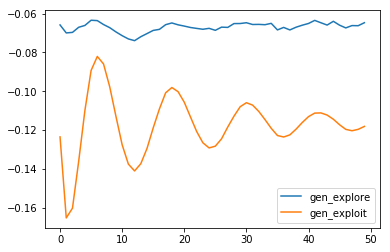

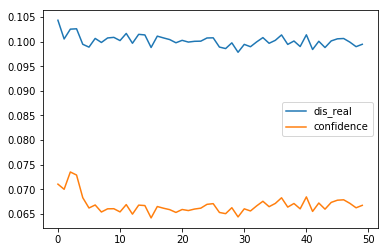

Generation 6  fitness : -6.605552448306245
#################################
Measured population fitness : 3s
population fitness : [ -92.89372541  -93.05850869  -30.61917259 -111.41850687  -50.65070732
  -24.83992503 -102.78609518 -117.08955424  -93.83404431  -96.26937244]
mean fit : -81.3459612083133
tensor([-0.3214, -0.1580, -0.1572, -0.3228,  0.4490,  0.2473, -0.3717, -0.1587,
         0.1900, -0.1655,  0.1901,  0.3948, -0.3862, -0.1737,  0.6077,  0.4460,
         0.3856, -0.2449,  0.2172, -0.1871], device='cuda:0')
tensor([0.0166, 0.0190, 0.0196, 0.0189, 0.0179, 0.0179, 0.0213, 0.0244, 0.0247,
        0.0198, 0.0146, 0.0233, 0.0212, 0.0260, 0.0111, 0.0071, 0.0202, 0.0238,
        0.0186, 0.0220], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


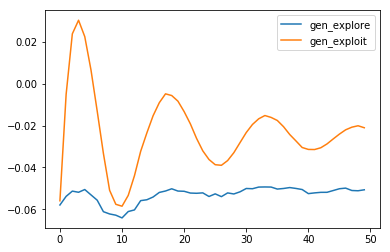

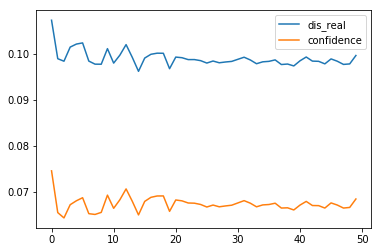

Generation 7  fitness : -24.839925030121265
#################################
Measured population fitness : 1s
population fitness : [-117.13638793 -119.92705622  -95.403092    -95.1474039   -98.78106948
  -93.67300858  -23.0515978  -100.41436966  -92.78890404  -95.79603989]
mean fit : -93.21189294957738
tensor([-0.1664, -0.3505, -0.1885, -0.1565, -0.1380, -0.1587,  0.4130, -0.1357,
        -0.3751, -0.2030,  0.4640, -0.1435, -0.3501, -0.1366, -0.3001,  0.4797,
        -0.1622, -0.2239, -0.1449,  0.2362], device='cuda:0')
tensor([-0.1011, -0.0950, -0.0936, -0.0754, -0.0734, -0.0834, -0.0852, -0.0764,
        -0.0771, -0.0948, -0.0789, -0.0738, -0.0962, -0.0806, -0.0817, -0.0744,
        -0.0795, -0.0821, -0.0879, -0.0833],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


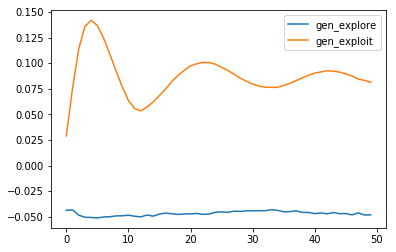

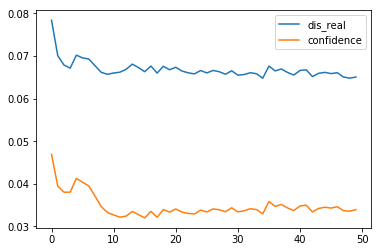

Generation 8  fitness : -23.05159779787391
#################################
Measured population fitness : 4s
population fitness : [ -31.78860671  -79.10946835  -93.55713918  -23.07107     -92.76831983
 -115.53483781  -25.24152956  -93.17151809  -98.93022487  -95.2418956 ]
mean fit : -74.84146100048498
tensor([-0.1380, -0.1598,  0.4001, -0.3777, -0.0175, -0.1590, -0.1382, -0.1450,
        -0.1460, -0.1924,  0.4772,  0.4579, -0.3530, -0.1647, -0.2055, -0.1613,
        -0.3389, -0.1416, -0.1911,  0.4770], device='cuda:0')
tensor([-0.0646, -0.0592, -0.0555, -0.0602, -0.0554, -0.0560, -0.0632, -0.0608,
        -0.0659, -0.0660, -0.0575, -0.0584, -0.0541, -0.0622, -0.0610, -0.0617,
        -0.0684, -0.0583, -0.0589, -0.0469],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


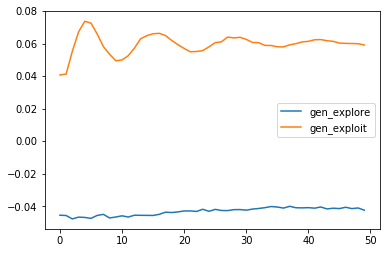

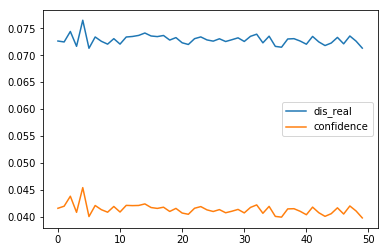

Generation 9  fitness : -23.07106999571638
#################################
Measured population fitness : 3s
population fitness : [-93.53678159 -32.26170595 -93.11774991 -92.25106234 -99.01190632
 -95.82753901 -98.45958963 -26.59073877 -94.56123269 -71.63945348]
mean fit : -79.72577596828691
tensor([ 0.0507, -0.1901, -0.1859, -0.3366, -0.1357,  0.4602, -0.1311, -0.0152,
        -0.1575, -0.1388,  0.3982, -0.1515,  0.4483, -0.1908, -0.1627, -0.1393,
         0.4793, -0.1425, -0.1427,  0.4024], device='cuda:0')
tensor([-0.0004, -0.0004, -0.0038, -0.0040, -0.0028,  0.0009, -0.0084,  0.0013,
        -0.0050, -0.0059, -0.0031, -0.0035,  0.0045, -0.0059, -0.0004,  0.0014,
         0.0029, -0.0047, -0.0041,  0.0010],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


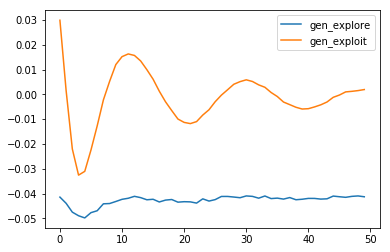

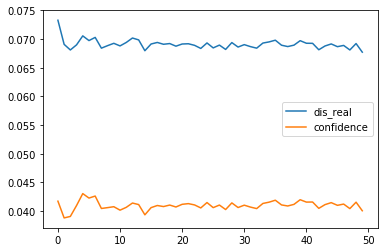

Generation 10  fitness : -26.590738772095694
#################################
Measured population fitness : 7s
population fitness : [-59.95370593 -22.34993398 -98.05677751 -93.4956073  -32.48157873
 -37.34142076 -56.05739044 -94.26062702 -32.00012713 -30.65590428]
mean fit : -55.665307307378626
tensor([-0.1486,  0.3808,  0.3831,  0.0333, -0.2034, -0.2082, -0.1663, -0.1599,
         0.3360,  0.1364, -0.1998, -0.1596, -0.1690, -0.1562,  0.1708,  0.3950,
         0.4683, -0.1801,  0.4308,  0.3789], device='cuda:0')
tensor([0.0725, 0.0644, 0.0658, 0.0675, 0.0720, 0.0636, 0.0705, 0.0667, 0.0670,
        0.0679, 0.0630, 0.0609, 0.0651, 0.0685, 0.0617, 0.0644, 0.0725, 0.0655,
        0.0644, 0.0640], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


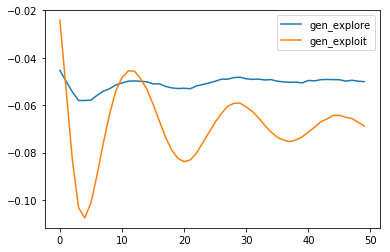

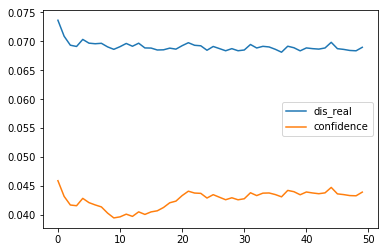

Generation 11  fitness : -22.349933975424424
#################################
Measured population fitness : 6s
population fitness : [-93.23177058 -48.02411695 -93.90799069 -56.2810448  -98.07266168
 -30.92027627  -9.38582582 -92.53409967 -21.93877961 -61.1104598 ]
mean fit : -60.54070258721263
tensor([ 0.2308,  0.4573,  0.1579, -0.1620,  0.1599,  0.3722, -0.1772, -0.1682,
         0.3250, -0.2109,  0.1255,  0.4610,  0.3679, -0.2107,  0.3817, -0.1741,
         0.5717, -0.1705,  0.3840,  0.1153], device='cuda:0')
tensor([0.1486, 0.1426, 0.1470, 0.1357, 0.1395, 0.1486, 0.1396, 0.1370, 0.1512,
        0.1370, 0.1339, 0.1389, 0.1416, 0.1534, 0.1532, 0.1470, 0.1487, 0.1550,
        0.1529, 0.1376], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


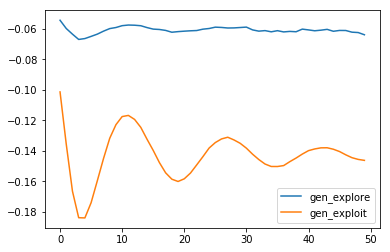

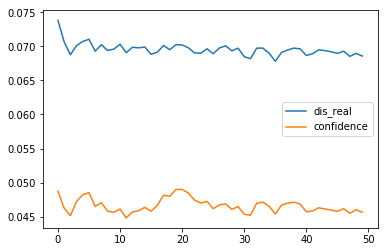

Generation 12  fitness : -9.385825815280745
#################################
Measured population fitness : 5s
population fitness : [-118.66110106  -32.83658663  -21.33968852  -27.57105075  -94.36328091
  -94.21255241  -52.52515283  -93.09268785  -93.25375983  -29.92833092]
mean fit : -65.77841917153918
tensor([ 0.4056,  0.2251,  0.1853,  0.4605, -0.2166, -0.1677, -0.3983,  0.1096,
        -0.1741,  0.4553, -0.1798,  0.3591, -0.1825, -0.1839, -0.1739, -0.1726,
         0.5660,  0.3848,  0.1522,  0.3760], device='cuda:0')
tensor([0.1049, 0.0986, 0.0961, 0.0695, 0.0724, 0.0854, 0.1070, 0.0922, 0.1062,
        0.0966, 0.1089, 0.0998, 0.0985, 0.0944, 0.1051, 0.0834, 0.0815, 0.0833,
        0.1011, 0.1021], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


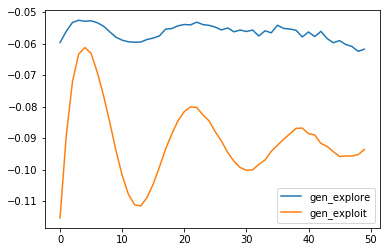

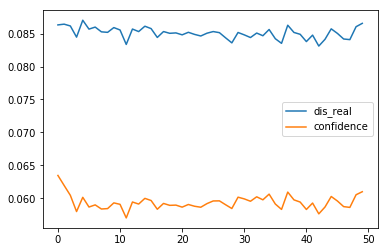

Generation 13  fitness : -21.339688517477256
#################################
Measured population fitness : 4s
population fitness : [ -32.67025818  -93.02713406 -100.98313952  -45.21287756  -97.13008378
  -41.15305406  -92.30668127  -98.33495475  -46.44081259 -121.0503841 ]
mean fit : -76.83093798685138
tensor([-0.1703, -0.1689,  0.4581, -0.2378, -0.1683, -0.2147,  0.4036, -0.1800,
        -0.2042,  0.3576,  0.2388, -0.1620, -0.3923,  0.2495, -0.1787,  0.3591,
        -0.4132,  0.3830,  0.1856,  0.2850], device='cuda:0')
tensor([0.0206, 0.0246, 0.0112, 0.0187, 0.0226, 0.0276, 0.0118, 0.0169, 0.0192,
        0.0078, 0.0193, 0.0284, 0.0212, 0.0135, 0.0294, 0.0280, 0.0138, 0.0260,
        0.0179, 0.0173], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


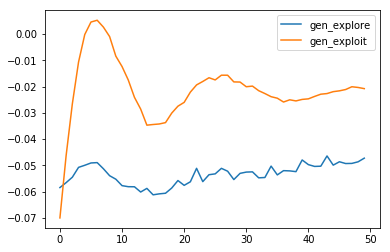

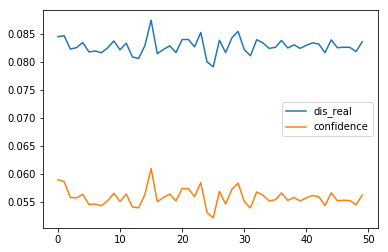

Generation 14  fitness : -32.67025817904746
#################################
Measured population fitness : 6s
population fitness : [-41.94675281 -32.99480821 -38.57104551 -93.61988536 -93.47136858
 -92.82542409 -28.30196446 -27.78562049 -58.41641051 -94.34632613]
mean fit : -60.2279606157521
tensor([ 0.3939,  0.3484, -0.1877,  0.2996, -0.1801, -0.1699, -0.1762, -0.2226,
         0.2309, -0.1744, -0.4211,  0.2701, -0.1814,  0.2771,  0.3512,  0.3894,
         0.2416, -0.2457,  0.1262, -0.2120], device='cuda:0')
tensor([0.0089, 0.0241, 0.0049, 0.0675, 0.0616, 0.0850, 0.0076, 0.0529, 0.0086,
        0.0651, 0.0356, 0.0459, 0.0357, 0.0541, 0.0311, 0.0215, 0.0164, 0.0678,
        0.0404, 0.0305], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


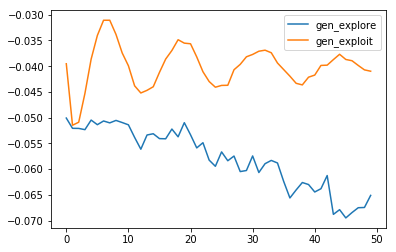

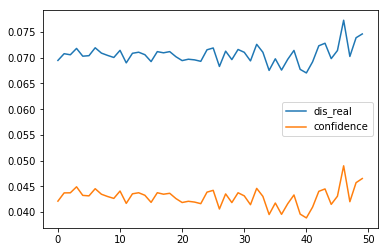

Generation 15  fitness : -27.785620491281247
#################################
Measured population fitness : 6s
population fitness : [-119.21885749  -24.4650614   -51.64575787  -95.31294008  -25.76654122
  -61.90229751  -94.09595892  -26.99464148  -97.75151833  -30.45772862]
mean fit : -62.761130292283305
tensor([ 0.3650,  0.3838,  0.4060,  0.1207,  0.3428, -0.2230,  0.2646,  0.1799,
        -0.1869, -0.1800,  0.4174, -0.1932, -0.1911,  0.2941, -0.4106,  0.3884,
         0.3953, -0.2017, -0.1856,  0.0903], device='cuda:0')
tensor([0.0919, 0.0886, 0.0879, 0.0884, 0.1072, 0.0980, 0.0961, 0.0958, 0.0929,
        0.0872, 0.0806, 0.0997, 0.0942, 0.0954, 0.0863, 0.0962, 0.1048, 0.0954,
        0.0948, 0.0942], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


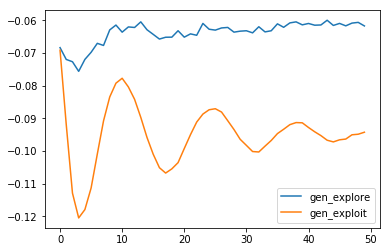

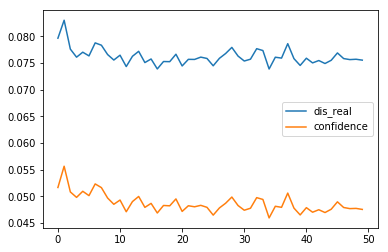

Generation 16  fitness : -24.465061402213394
#################################
Measured population fitness : 9s
population fitness : [-26.91242837 -36.26641575 -48.97331095 -29.56569266 -26.00589812
 -31.22696822 -92.8319947  -23.48510377 -32.77819779 -54.09987538]
mean fit : -40.2145885736226
tensor([-0.4270, -0.2075,  0.3875, -0.2394,  0.2978,  0.4095,  0.1868, -0.1965,
         0.3486,  0.4009,  0.3895,  0.0738, -0.2181,  0.3418,  0.3795,  0.3283,
         0.1634,  0.3563,  0.1420,  0.3788], device='cuda:0')
tensor([0.1670, 0.1691, 0.1536, 0.1631, 0.1636, 0.1613, 0.1673, 0.1700, 0.1552,
        0.1657, 0.1549, 0.1550, 0.1620, 0.1777, 0.1711, 0.1658, 0.1611, 0.1663,
        0.1792, 0.1669], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


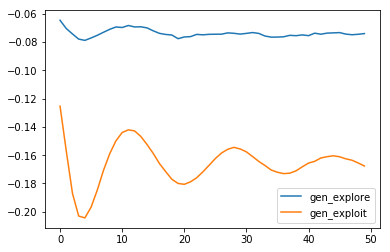

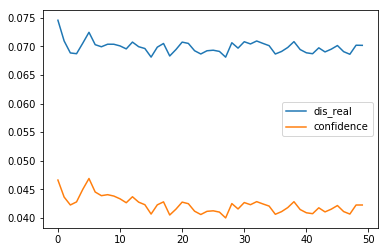

Generation 17  fitness : -23.485103774785493
#################################
Measured population fitness : 8s
population fitness : [-119.33496623  -10.59601702  -21.45610923  -92.8333933   -57.05481395
  -31.60586205  -33.24789832  -39.77634016  -33.31576963  -30.21074073]
mean fit : -46.943191061388
tensor([ 0.4158, -0.4394,  0.2558,  0.3761,  0.2864,  0.3169,  0.3272,  0.3393,
         0.3122,  0.3682,  0.3305,  0.1754,  0.3450,  0.3981, -0.2078,  0.1048,
         0.5107, -0.2078,  0.3128,  0.1306], device='cuda:0')
tensor([0.2302, 0.2250, 0.2243, 0.2154, 0.2190, 0.2133, 0.2240, 0.2265, 0.2243,
        0.2221, 0.2212, 0.2232, 0.2286, 0.2245, 0.2254, 0.2199, 0.2248, 0.2257,
        0.2244, 0.2250], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


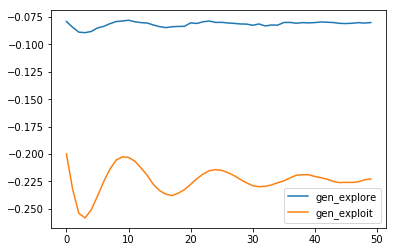

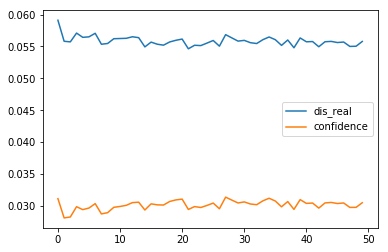

Generation 18  fitness : -10.596017018125716
#################################
Measured population fitness : 7s
population fitness : [ -21.45106112  -23.33309869  -35.29568473  -64.0131164   -20.57221348
 -111.90835921  -22.06209694 -125.33369284  -36.03613242  -92.97937854]
mean fit : -55.2984834368542
tensor([ 0.4862, -0.3671,  0.2719,  0.3896,  0.3789,  0.3210,  0.0949,  0.3947,
         0.2949,  0.2404,  0.2954,  0.3093,  0.4022, -0.4802, -0.4296, -0.2077,
         0.2782,  0.0363,  0.3948, -0.2064], device='cuda:0')
tensor([0.1369, 0.1382, 0.1597, 0.1382, 0.1593, 0.1568, 0.1561, 0.1547, 0.1518,
        0.1594, 0.1412, 0.1445, 0.1583, 0.1508, 0.1435, 0.1422, 0.1352, 0.1539,
        0.1444, 0.1416], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


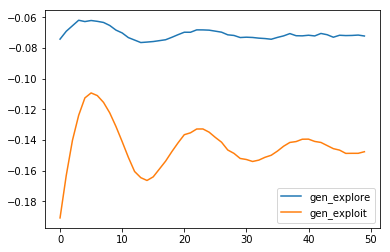

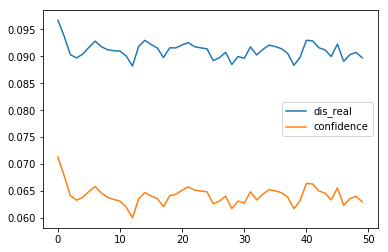

Generation 19  fitness : -20.57221348441493
#################################
Measured population fitness : 7s
population fitness : [ -96.19222561  -20.56726702  -18.01646127  -28.75292643  -33.37757714
  -27.81604853 -117.08208063  -33.88334245  -30.93685772  -93.79446915]
mean fit : -50.04192559421409
tensor([ 0.2642, -0.4184, -0.2154, -0.2222,  0.3072, -0.2424,  0.2705,  0.3712,
        -0.3748,  0.3871,  0.3335,  0.0286,  0.4160,  0.3819, -0.4879,  0.3945,
         0.3256,  0.2824,  0.3945,  0.2866], device='cuda:0')
tensor([0.1277, 0.1408, 0.1180, 0.1178, 0.1379, 0.1356, 0.1257, 0.1178, 0.1201,
        0.1269, 0.0847, 0.1243, 0.1389, 0.1318, 0.1305, 0.1305, 0.1304, 0.1455,
        0.0716, 0.1330], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


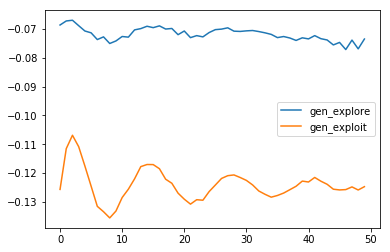

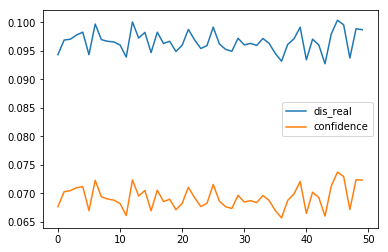

Generation 20  fitness : -18.016461265602835
#################################
Measured population fitness : 7s
population fitness : [-117.918094    -63.87136868  -20.45191559  -29.80207266 -113.12944521
  -24.53223036  -18.74246582  -95.11456071  -28.30428703  -36.04767466]
mean fit : -54.79141147150951
tensor([-0.2384, -0.3901,  0.3243,  0.3895,  0.3561, -0.2273, -0.2475,  0.4110,
        -0.4305,  0.3284,  0.2816,  0.0247, -0.4234,  0.3021,  0.3904,  0.2773,
         0.4048,  0.3117,  0.2591,  0.3205], device='cuda:0')
tensor([0.1089, 0.1482, 0.1086, 0.1065, 0.1061, 0.1194, 0.1346, 0.1315, 0.1253,
        0.1222, 0.1234, 0.1213, 0.1284, 0.1342, 0.1211, 0.0968, 0.1225, 0.1046,
        0.1163, 0.1261], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


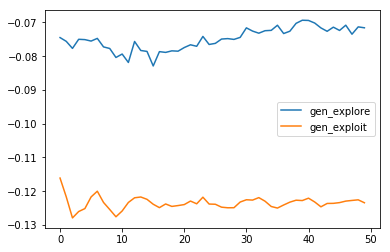

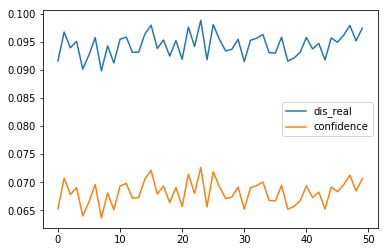

Generation 21  fitness : -18.742465824930026
#################################
Measured population fitness : 8s
population fitness : [-18.74513153 -18.7101216  -30.89167461 -36.27942996 -20.36224279
 -95.94895432 -33.72502841 -37.56658037 -99.32872338 -26.14183686]
mean fit : -41.769972383158844
tensor([ 0.3147,  0.3021,  0.3329,  0.2367,  0.3465, -0.2835,  0.2476,  0.3953,
         0.2495,  0.2691,  0.2929, -0.3997, -0.2480, -0.2550,  0.3955,  0.3816,
         0.3809,  0.0152,  0.3952, -0.4401], device='cuda:0')
tensor([0.1504, 0.1473, 0.1489, 0.1497, 0.1587, 0.1550, 0.1558, 0.1499, 0.1512,
        0.1464, 0.1329, 0.1468, 0.1169, 0.1456, 0.1315, 0.1425, 0.1513, 0.1490,
        0.1537, 0.1477], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


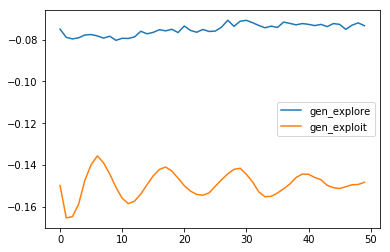

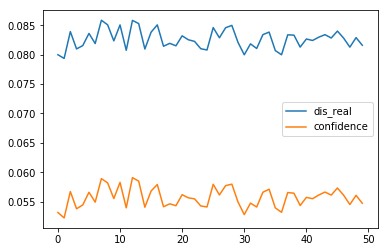

Generation 22  fitness : -18.710121595047795
#################################
Measured population fitness : 9s
population fitness : [-31.21749745 -17.26571015 -29.70710249 -94.27017308 -22.62082662
 -38.59746662 -24.06047611 -21.75210269 -36.80136464 -28.80332408]
mean fit : -34.509604393008004
tensor([ 0.2361,  0.2317,  0.3215,  0.2577,  0.2815, -0.2523,  0.3512,  0.3838,
         0.2915,  0.2166,  0.3963,  0.2788,  0.3391,  0.3702,  0.2991, -0.2949,
         0.3841,  0.2253,  0.3585, -0.2664], device='cuda:0')
tensor([0.2254, 0.2245, 0.2217, 0.2219, 0.2224, 0.2265, 0.2245, 0.2253, 0.2266,
        0.2225, 0.2297, 0.2253, 0.2053, 0.1952, 0.2320, 0.2050, 0.2283, 0.2270,
        0.2330, 0.2243], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


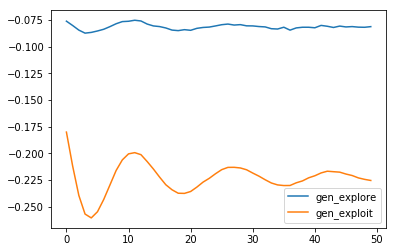

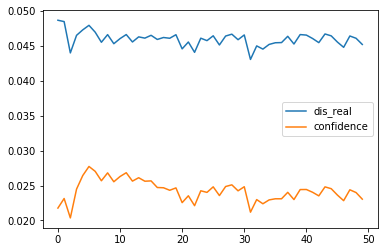

Generation 23  fitness : -17.265710153482203
#################################
Measured population fitness : 10s
population fitness : [-31.00547991 -31.5799304  -26.96212152 -18.86350568 -14.84954811
 -36.98122219 -21.77443986 -33.52330449 -38.93812594 -19.83635185]
mean fit : -27.43140299534101
tensor([ 0.2008,  0.3456,  0.3261,  0.3382,  0.2862,  0.3833,  0.2188,  0.3017,
         0.3617,  0.4037,  0.2786,  0.2464, -0.2652,  0.3454,  0.2037,  0.2628,
         0.2676,  0.3699,  0.2658,  0.2173], device='cuda:0')
tensor([0.2688, 0.2678, 0.2718, 0.2725, 0.2624, 0.2702, 0.2709, 0.2690, 0.2700,
        0.2694, 0.2716, 0.2778, 0.2708, 0.2721, 0.2683, 0.2692, 0.2709, 0.2700,
        0.2674, 0.2701], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


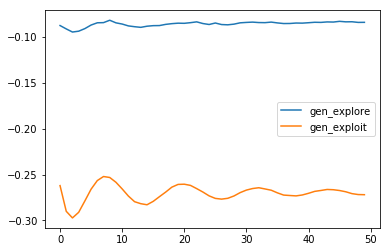

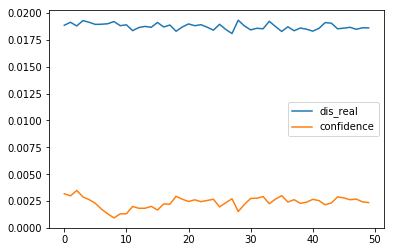

Generation 24  fitness : -14.849548113973492
#################################
Measured population fitness : 9s
population fitness : [-15.43056129 -19.58688603 -25.90848101 -35.82154368 -21.06609026
 -33.76515906 -30.69691737 -30.51176744 -27.89705473 -27.1249698 ]
mean fit : -26.78094306819242
tensor([0.2506, 0.2817, 0.2596, 0.2984, 0.2581, 0.3867, 0.2555, 0.3392, 0.2149,
        0.2343, 0.3496, 0.1887, 0.3517, 0.2882, 0.3916, 0.2052, 0.2322, 0.2895,
        0.3578, 0.3332], device='cuda:0')
tensor([0.2914, 0.2916, 0.2873, 0.2917, 0.2891, 0.2884, 0.2859, 0.2868, 0.2879,
        0.2907, 0.2922, 0.2901, 0.2887, 0.2895, 0.2891, 0.2905, 0.2893, 0.2898,
        0.2883, 0.2876], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


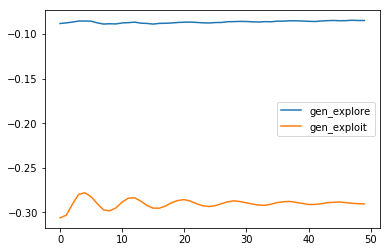

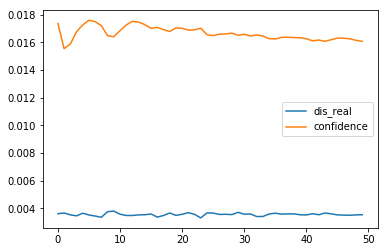

Generation 25  fitness : -15.430561294198606
#################################
Measured population fitness : 9s
population fitness : [-19.15423076 -34.32752329 -40.14471552 -35.9302332  -37.44912069
 -21.2486388  -19.782136   -36.25234358 -13.53698654 -26.8909464 ]
mean fit : -28.47168747909552
tensor([0.1679, 0.3270, 0.2169, 0.1906, 0.2710, 0.2878, 0.2490, 0.2034, 0.2775,
        0.3760, 0.2043, 0.2474, 0.3920, 0.2795, 0.3410, 0.3286, 0.3394, 0.3447,
        0.2216, 0.2006], device='cuda:0')
tensor([0.2724, 0.2711, 0.2778, 0.2739, 0.2739, 0.2727, 0.2715, 0.2729, 0.2761,
        0.2758, 0.2718, 0.2721, 0.2737, 0.2731, 0.2744, 0.2729, 0.2709, 0.2796,
        0.2707, 0.2765], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


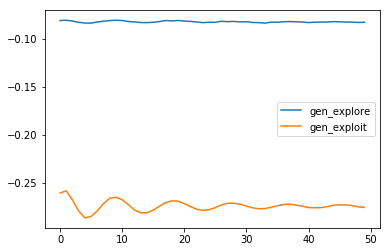

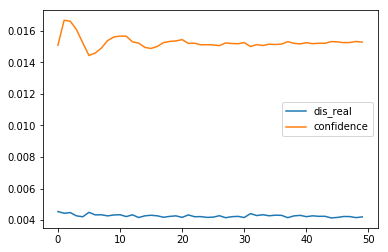

Generation 26  fitness : -13.536986537001553
#################################
Measured population fitness : 9s
population fitness : [-20.26820593 -30.70159955 -26.51929827 -22.3356608  -32.59324352
 -19.10434836 -25.22509046 -25.58911382 -18.25223909 -36.86301642]
mean fit : -25.745181621810808
tensor([0.2828, 0.2688, 0.2798, 0.3246, 0.3344, 0.3072, 0.2719, 0.3287, 0.2208,
        0.1572, 0.1899, 0.3415, 0.1799, 0.1927, 0.3163, 0.3340, 0.2367, 0.3813,
        0.1848, 0.2062], device='cuda:0')
tensor([0.2651, 0.2675, 0.2643, 0.2673, 0.2705, 0.2652, 0.2663, 0.2641, 0.2680,
        0.2677, 0.2654, 0.2650, 0.2641, 0.2669, 0.2672, 0.2641, 0.2681, 0.2644,
        0.2652, 0.2667], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


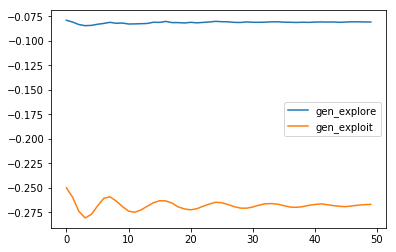

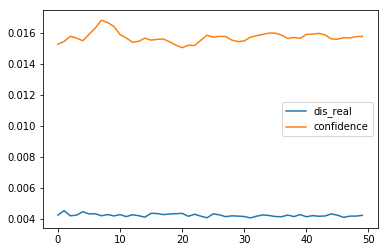

Generation 27  fitness : -18.252239089225498
#################################
Measured population fitness : 10s
population fitness : [-21.55572078 -31.52195523 -39.80329041 -22.84037934 -15.86849986
 -27.56127609 -35.07430474 -29.54187483 -26.12660044 -45.47065124]
mean fit : -29.536455295817582
tensor([0.2984, 0.2941, 0.2740, 0.3528, 0.1512, 0.2631, 0.3049, 0.2210, 0.2120,
        0.2377, 0.2279, 0.3327, 0.1760, 0.3256, 0.2709, 0.3158, 0.1035, 0.2664,
        0.2543, 0.1911], device='cuda:0')
tensor([0.2546, 0.2562, 0.2550, 0.2565, 0.2581, 0.2553, 0.2526, 0.2510, 0.2536,
        0.2548, 0.2546, 0.2602, 0.2551, 0.2543, 0.2528, 0.2534, 0.2541, 0.2593,
        0.2533, 0.2535], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


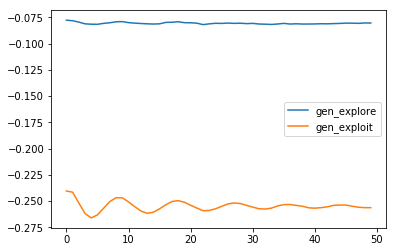

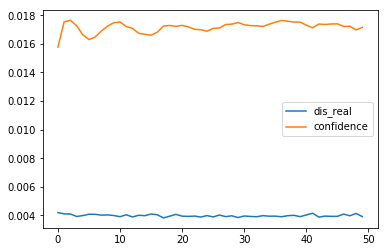

Generation 28  fitness : -15.868499863932458
#################################
Measured population fitness : 9s
population fitness : [-31.3875179  -35.33019942 -20.74004321 -27.23972926 -24.40699691
 -16.53393915 -39.27901051 -27.10536896 -35.77957065 -22.62533548]
mean fit : -28.04277114433976
tensor([0.2123, 0.2495, 0.0949, 0.1470, 0.1765, 0.2290, 0.3032, 0.2855, 0.1824,
        0.2135, 0.2873, 0.3386, 0.2963, 0.2578, 0.2457, 0.2484, 0.1803, 0.3442,
        0.1426, 0.2723], device='cuda:0')
tensor([0.2377, 0.2394, 0.2303, 0.2426, 0.2325, 0.2381, 0.2321, 0.2329, 0.2360,
        0.2300, 0.2340, 0.2296, 0.2312, 0.2320, 0.2331, 0.2318, 0.2379, 0.2408,
        0.2345, 0.2391], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


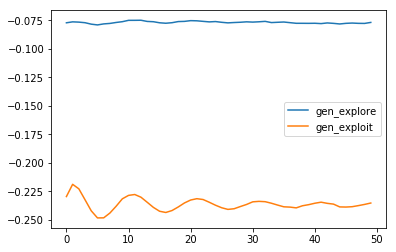

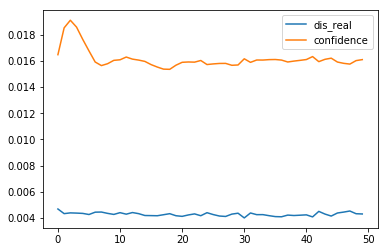

Generation 29  fitness : -16.533939150159988
#################################
Measured population fitness : 9s
population fitness : [-27.94444782 -17.16093023 -21.07851074 -33.14234959 -27.23096135
 -29.95688925 -23.72856564 -23.66693763 -44.71400922 -16.84412251]
mean fit : -26.546772397382085
tensor([0.1902, 0.3275, 0.1385, 0.1718, 0.2918, 0.2638, 0.2700, 0.3248, 0.1680,
        0.0928, 0.2411, 0.2947, 0.2695, 0.2400, 0.2399, 0.2340, 0.3301, 0.2788,
        0.2171, 0.2050], device='cuda:0')
tensor([0.2351, 0.2407, 0.2367, 0.2425, 0.2362, 0.2398, 0.2350, 0.2410, 0.2382,
        0.2451, 0.2400, 0.2404, 0.2363, 0.2357, 0.2389, 0.2426, 0.2373, 0.2391,
        0.2426, 0.2343], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


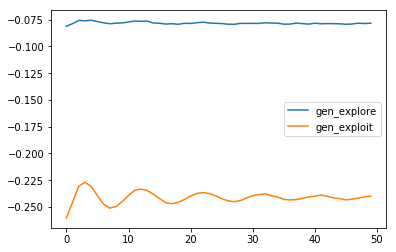

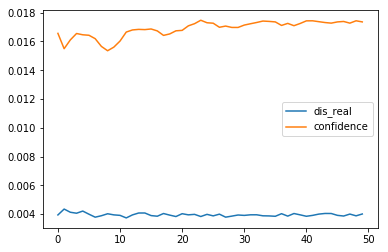

Generation 30  fitness : -16.844122513839984
#################################
Measured population fitness : 9s
population fitness : [-26.49834188 -16.40423263 -31.04207389 -99.93564656 -26.26891301
 -10.15633385 -20.33262215 -32.74740469 -18.29604922 -31.8379614 ]
mean fit : -31.351957927344284
tensor([ 0.2629,  0.1946,  0.2852,  0.3182,  0.1836,  0.3209,  0.3246,  0.2104,
         0.2915,  0.2274,  0.3772,  0.2013,  0.0861,  0.3086,  0.2334,  0.2396,
         0.2634, -0.3790,  0.1869,  0.2415], device='cuda:0')
tensor([0.2205, 0.2198, 0.2190, 0.2197, 0.2154, 0.2186, 0.2189, 0.2213, 0.2203,
        0.2193, 0.2187, 0.2160, 0.2216, 0.2150, 0.2139, 0.2218, 0.2216, 0.2251,
        0.2242, 0.2190], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


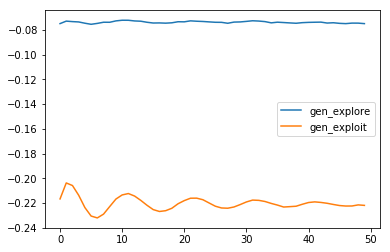

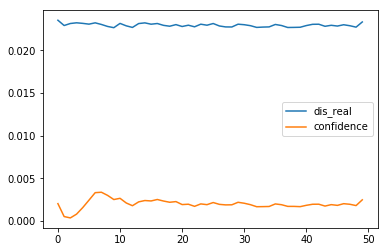

Generation 31  fitness : -10.156333849297802
#################################
Measured population fitness : 8s
population fitness : [-112.45558385  -38.58533466  -14.81399808  -23.60558044  -12.90151584
  -29.96087841  -13.44033959  -23.79451766  -23.83451091  -23.95093264]
mean fit : -31.734319208522738
tensor([ 0.3711,  0.3319,  0.2335,  0.2043,  0.3185,  0.2549,  0.1885, -0.4905,
         0.2559,  0.3480,  0.3025,  0.3434,  0.2354,  0.2578,  0.1952,  0.1808,
         0.2854,  0.1316,  0.2562, -0.3851], device='cuda:0')
tensor([0.1874, 0.1910, 0.1824, 0.1826, 0.1815, 0.1964, 0.1867, 0.1905, 0.1836,
        0.1912, 0.1916, 0.1835, 0.1929, 0.1842, 0.1861, 0.1869, 0.1896, 0.1892,
        0.1900, 0.1833], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


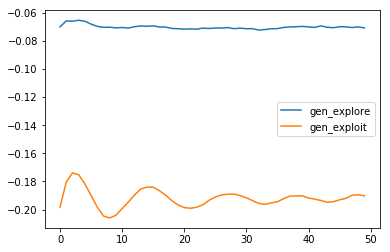

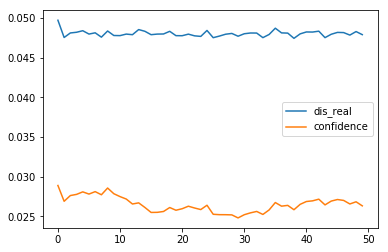

Generation 32  fitness : -12.901515844870461
#################################
Measured population fitness : 8s
population fitness : [ -37.48009526  -22.17285836  -32.30604854  -21.80105411  -32.11165794
  -10.37395161  -22.24061341  -20.44818667  -36.88335279 -115.23978831]
mean fit : -35.10576070017579
tensor([ 0.1994,  0.2644,  0.3431,  0.2529,  0.1361, -0.5189,  0.2500,  0.1411,
         0.1797,  0.3386,  0.2650,  0.2513,  0.1268,  0.2795,  0.3644,  0.2510,
         0.2681, -0.4954,  0.3270,  0.1813], device='cuda:0')
tensor([0.1715, 0.1668, 0.1708, 0.1737, 0.1740, 0.1678, 0.1708, 0.1709, 0.1735,
        0.1734, 0.1737, 0.1712, 0.1723, 0.1705, 0.1679, 0.1734, 0.1693, 0.1714,
        0.1758, 0.1746], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


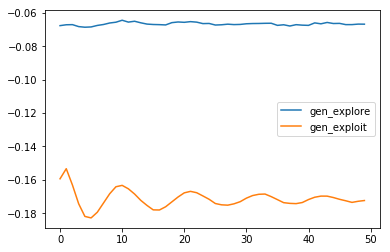

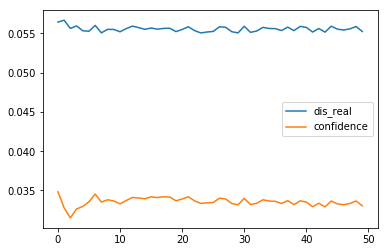

Generation 33  fitness : -10.373951612469925
#################################
Measured population fitness : 9s
population fitness : [-32.42899082 -15.4397782  -19.1828301  -36.21635133 -18.00056408
 -32.00046461 -24.75540185 -23.27569861 -22.45355863 -30.91809725]
mean fit : -25.467173546547777
tensor([ 0.2832,  0.2612,  0.2363,  0.1397,  0.3147,  0.1753, -0.5258,  0.1743,
         0.1727,  0.3574,  0.2557,  0.1341,  0.2932,  0.2487,  0.2580,  0.2726,
         0.1291,  0.2575,  0.1844,  0.1716], device='cuda:0')
tensor([0.1897, 0.1913, 0.1882, 0.1870, 0.1895, 0.1913, 0.1898, 0.1851, 0.1849,
        0.1832, 0.1936, 0.1882, 0.1867, 0.1892, 0.1845, 0.1919, 0.1907, 0.1899,
        0.1864, 0.1875], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


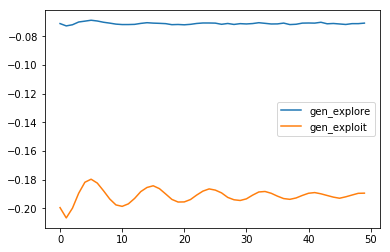

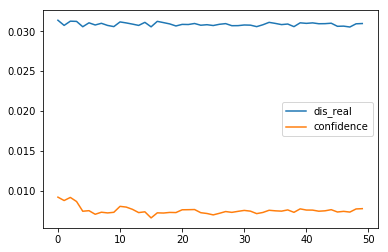

Generation 34  fitness : -15.439778198188666
#################################
Measured population fitness : 10s
population fitness : [-26.30768855 -30.33885751 -30.175813   -50.56054577 -14.56832799
 -27.74712657 -19.49864232 -29.22967228 -21.80488705 -34.86233271]
mean fit : -28.5093893760602
tensor([0.1785, 0.2774, 0.1658, 0.1834, 0.2747, 0.0131, 0.2429, 0.1453, 0.3089,
        0.1339, 0.2174, 0.1927, 0.2873, 0.1848, 0.2052, 0.2304, 0.2553, 0.1694,
        0.2498, 0.3162], device='cuda:0')
tensor([0.2102, 0.2098, 0.2097, 0.2078, 0.2097, 0.2112, 0.2123, 0.2121, 0.2104,
        0.2159, 0.2102, 0.2092, 0.2116, 0.2108, 0.2082, 0.2113, 0.2111, 0.2130,
        0.2113, 0.2117], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


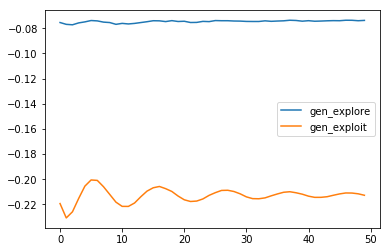

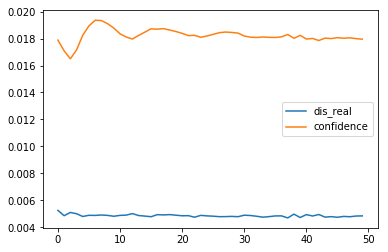

Generation 35  fitness : -14.56832799067307
#################################
Measured population fitness : 9s
population fitness : [-17.10969504 -28.55513653 -24.27433197 -28.80623695 -27.88323619
 -36.12264548 -21.16847909 -25.51585035  -7.86559493 -18.44210723]
mean fit : -23.57433137605447
tensor([0.2540, 0.1986, 0.2882, 0.2278, 0.1781, 0.1896, 0.1861, 0.3660, 0.1386,
        0.2486, 0.2769, 0.2680, 0.3096, 0.1280, 0.1974, 0.2173, 0.0064, 0.1917,
        0.1767, 0.2107], device='cuda:0')
tensor([0.2147, 0.2111, 0.2155, 0.2135, 0.2098, 0.2182, 0.2121, 0.2139, 0.2111,
        0.2093, 0.2124, 0.2107, 0.2106, 0.2129, 0.2126, 0.2108, 0.2153, 0.2124,
        0.2105, 0.2111], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


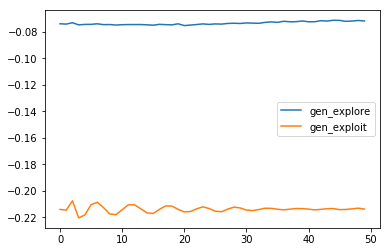

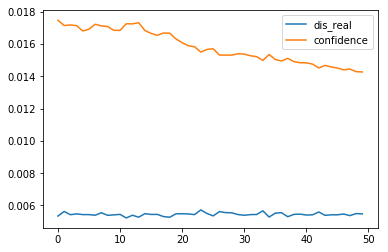

Generation 36  fitness : -7.865594931247998
#################################
Measured population fitness : 9s
population fitness : [-22.29871673 -10.28598225 -25.53906093 -18.03243485 -29.77283416
 -32.81408223 -27.87746409 -21.91399667 -32.0551851   -8.49949011]
mean fit : -22.908924711814098
tensor([0.2107, 0.2380, 0.1750, 0.3595, 0.1909, 0.2705, 0.3542, 0.1215, 0.2817,
        0.2412, 0.2475, 0.1832, 0.1853, 0.2109, 0.1910, 0.3392, 0.1558, 0.1494,
        0.2213, 0.2739], device='cuda:0')
tensor([0.2294, 0.2337, 0.2278, 0.2342, 0.2327, 0.2288, 0.2289, 0.2323, 0.2319,
        0.2293, 0.2302, 0.2296, 0.2313, 0.2321, 0.2323, 0.2317, 0.2353, 0.2340,
        0.2282, 0.2311], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


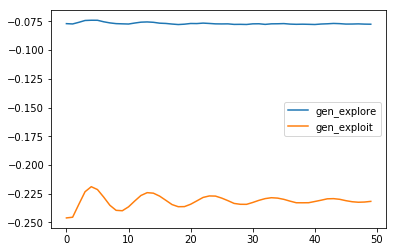

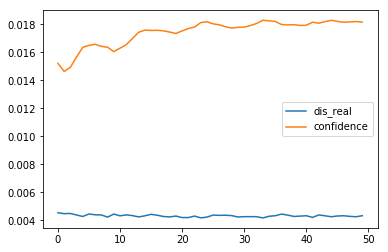

Generation 37  fitness : -8.499490106225087
#################################
Measured population fitness : 10s
population fitness : [-23.9627163  -31.87537421 -33.26287251 -20.82933812 -37.28498678
 -27.1180351  -19.73082133 -31.82066852 -18.0551591  -29.10636627]
mean fit : -27.304633825090377
tensor([0.2452, 0.2545, 0.2361, 0.1522, 0.1405, 0.1858, 0.2686, 0.3340, 0.3490,
        0.2188, 0.2328, 0.1506, 0.1526, 0.2055, 0.1699, 0.1066, 0.2688, 0.1443,
        0.1922, 0.1755], device='cuda:0')
tensor([0.2102, 0.2101, 0.2128, 0.2092, 0.2121, 0.2075, 0.2126, 0.2075, 0.2110,
        0.2104, 0.2102, 0.2093, 0.2115, 0.2138, 0.2105, 0.2084, 0.2088, 0.2112,
        0.2097, 0.2111], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


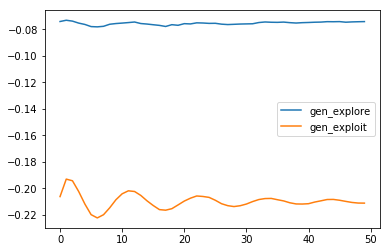

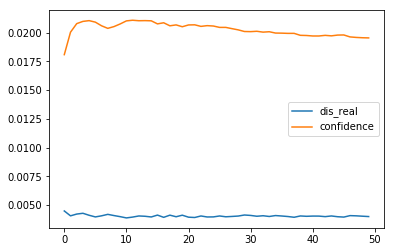

Generation 38  fitness : -18.055159103132162
#################################
Measured population fitness : 9s
population fitness : [ -4.67578689 -28.91830366 -39.29163046 -30.40851516 -26.47656717
 -27.79774776 -24.02197768 -21.78371879 -31.38968233 -20.55692111]
mean fit : -25.5320851014177
tensor([0.1486, 0.2096, 0.1450, 0.1567, 0.2383, 0.1840, 0.2361, 0.0997, 0.1691,
        0.1675, 0.1445, 0.2282, 0.1893, 0.1330, 0.2452, 0.2101, 0.1783, 0.0831,
        0.3700, 0.2591], device='cuda:0')
tensor([0.1912, 0.1885, 0.1891, 0.1954, 0.1935, 0.1902, 0.1903, 0.1872, 0.1907,
        0.1893, 0.1864, 0.1906, 0.1891, 0.1945, 0.1894, 0.1898, 0.1906, 0.1924,
        0.1889, 0.1913], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


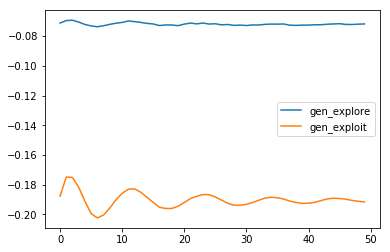

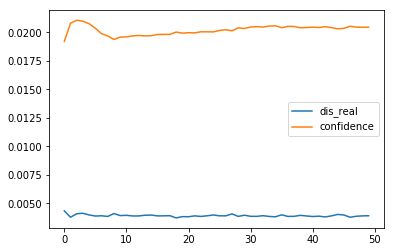

Generation 39  fitness : -4.675786892431473
#################################
Measured population fitness : 10s
population fitness : [-33.86211943 -18.86541101 -30.77078639 -23.51459763 -22.73474634
 -20.48777043 -26.34136601 -35.62851354 -32.08332691 -24.95479106]
mean fit : -26.92434287543511
tensor([0.3653, 0.1521, 0.1439, 0.1491, 0.2157, 0.2235, 0.1234, 0.1088, 0.1382,
        0.2092, 0.1644, 0.0784, 0.2477, 0.1846, 0.2050, 0.1737, 0.2343, 0.2337,
        0.1973, 0.1858], device='cuda:0')
tensor([0.1885, 0.1838, 0.1891, 0.1859, 0.1830, 0.1895, 0.1937, 0.1881, 0.1871,
        0.1892, 0.1871, 0.1865, 0.1885, 0.1860, 0.1850, 0.1912, 0.1861, 0.1893,
        0.1859, 0.1873], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


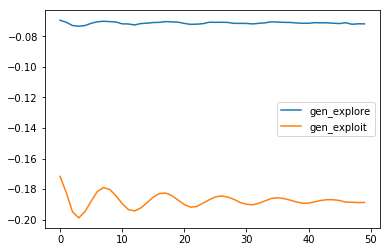

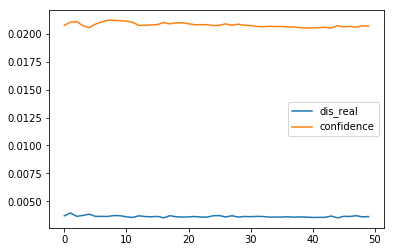

Generation 40  fitness : -18.865411010963072
#################################
Measured population fitness : 9s
population fitness : [ -36.24470112  -17.06719142 -119.83162569  -23.93684932  -33.64057488
  -23.41589826  -14.20398406  -30.31270556  -28.6898304   -28.47778067]
mean fit : -35.58211413784117
tensor([ 0.2600,  0.1355,  0.1010,  0.2074,  0.2030,  0.2130,  0.1946,  0.2065,
        -0.5917,  0.1502,  0.2451,  0.1831,  0.1208,  0.2837,  0.1636,  0.2316,
         0.1061,  0.1654,  0.1226,  0.1464], device='cuda:0')
tensor([0.1359, 0.1417, 0.1414, 0.1465, 0.1384, 0.1413, 0.1397, 0.1400, 0.1407,
        0.1444, 0.1372, 0.1440, 0.1420, 0.1414, 0.1391, 0.1430, 0.1418, 0.1391,
        0.1422, 0.1438], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


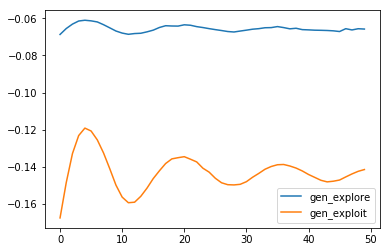

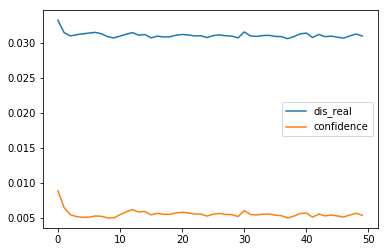

Generation 41  fitness : -14.203984064417527
#################################
Measured population fitness : 10s
population fitness : [-31.11722031 -31.94905396 -28.32886801 -26.74029579 -20.45578595
 -31.33447586 -35.75444793 -22.57213845 -25.84419674 -21.09703703]
mean fit : -27.519352002921458
tensor([ 0.1461,  0.1625,  0.1010,  0.1595,  0.1376,  0.1613,  0.2558,  0.1185,
         0.1831,  0.1757,  0.2278,  0.1394, -0.5959,  0.1325,  0.2796,  0.2224,
         0.0969,  0.2032,  0.1989,  0.2102], device='cuda:0')
tensor([0.1373, 0.1345, 0.1321, 0.1318, 0.1381, 0.1363, 0.1422, 0.1388, 0.1388,
        0.1361, 0.1344, 0.1396, 0.1398, 0.1347, 0.1348, 0.1352, 0.1368, 0.1337,
        0.1358, 0.1366], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


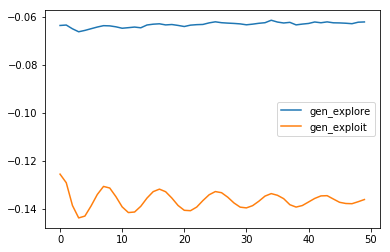

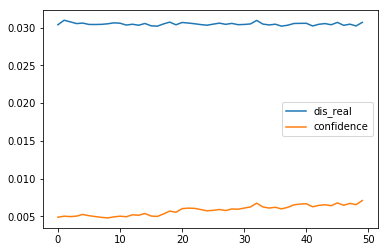

Generation 42  fitness : -20.455785948799306
#################################
Measured population fitness : 9s
population fitness : [-30.55437984 -27.42112641 -17.90394514 -20.30127708 -31.943557
 -27.12052001 -59.54942145 -68.55726146 -36.33808649 -20.29729238]
mean fit : -33.99868672728059
tensor([ 0.1298,  0.1598,  0.1730,  0.2198,  0.2075,  0.1673,  0.0983, -0.0989,
         0.2462, -0.1736,  0.1367,  0.0934,  0.1698,  0.1349,  0.1414,  0.2264,
         0.2251,  0.1804,  0.2264,  0.1299], device='cuda:0')
tensor([0.1408, 0.1379, 0.1385, 0.1420, 0.1386, 0.1396, 0.1410, 0.1388, 0.1405,
        0.1372, 0.1390, 0.1401, 0.1412, 0.1395, 0.1400, 0.1403, 0.1405, 0.1409,
        0.1400, 0.1394], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


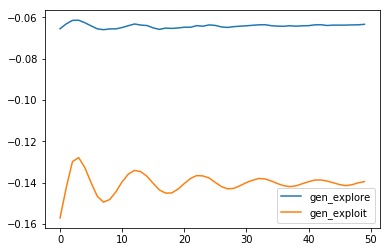

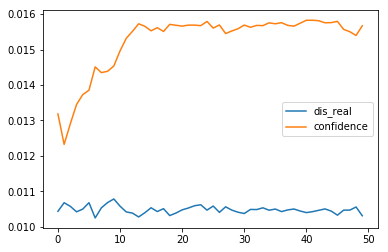

Generation 43  fitness : -17.903945144103254
#################################
Measured population fitness : 9s
population fitness : [-55.64342502 -27.05703957 -37.25678615 -21.75340717 -20.27325835
 -42.02027768 -14.65075998 -38.09465535 -41.42348919 -32.64854599]
mean fit : -33.08216444447824
tensor([ 0.2704,  0.2116, -0.1763,  0.1213,  0.2238,  0.1271,  0.0436,  0.2435,
         0.1386, -0.0693,  0.0761, -0.1017,  0.0831,  0.0907,  0.2236,  0.2236,
         0.1671,  0.0486,  0.1646,  0.1676], device='cuda:0')
tensor([0.1160, 0.1164, 0.1137, 0.1175, 0.1123, 0.1156, 0.1149, 0.1161, 0.1165,
        0.1181, 0.1179, 0.1126, 0.1108, 0.1155, 0.1117, 0.1162, 0.1155, 0.1141,
        0.1121, 0.1105], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


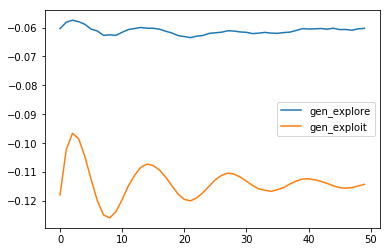

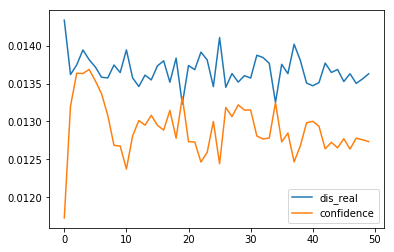

Generation 44  fitness : -14.65075997649105
#################################
Measured population fitness : 9s
population fitness : [ -18.77651224  -29.73942939  -31.09601109  -43.63274237  -29.48874314
  -45.32010947 -113.91721795  -30.95061598  -20.49097176  -28.61691732]
mean fit : -39.20292707200649
tensor([ 0.0421,  0.1661,  0.1339,  0.2224, -0.0708,  0.1532,  0.2690,  0.0816,
         0.1439,  0.1460,  0.1327,  0.2206,  0.0747,  0.2348,  0.0148, -0.5538,
         0.0471,  0.0288,  0.1198,  0.2101], device='cuda:0')
tensor([0.0907, 0.0943, 0.0895, 0.0918, 0.0850, 0.0955, 0.0937, 0.0859, 0.0854,
        0.0861, 0.0932, 0.0875, 0.0833, 0.0912, 0.0883, 0.0943, 0.0920, 0.0850,
        0.0868, 0.0933], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


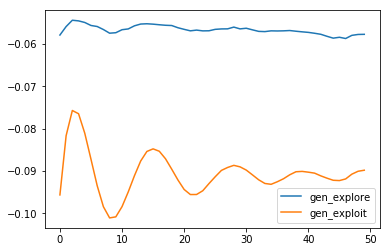

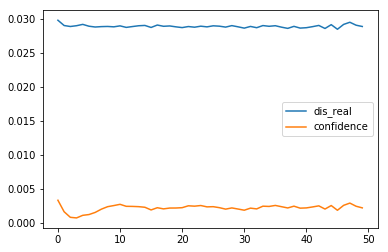

Generation 45  fitness : -18.77651224407322
#################################
Measured population fitness : 8s
population fitness : [ -30.19386823  -25.78686362  -31.79911983  -22.49449924  -45.63213881
  -37.16617334  -50.98035313  -23.59421758 -120.0988758   -34.69222766]
mean fit : -42.24383372370967
tensor([ 0.0279, -0.5546,  0.0113,  0.1940,  0.1393,  0.1260,  0.2031,  0.0815,
         0.1330,  0.1318,  0.1020,  0.1451, -0.0330,  0.1523,  0.2339, -0.6059,
         0.0139,  0.1430,  0.2197,  0.1758], device='cuda:0')
tensor([0.0601, 0.0602, 0.0587, 0.0572, 0.0454, 0.0585, 0.0454, 0.0573, 0.0572,
        0.0530, 0.0448, 0.0460, 0.0557, 0.0541, 0.0461, 0.0554, 0.0602, 0.0601,
        0.0454, 0.0575], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


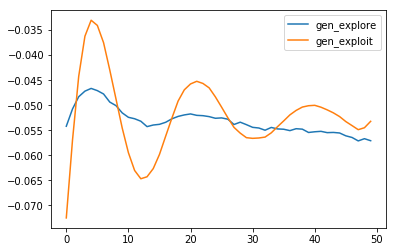

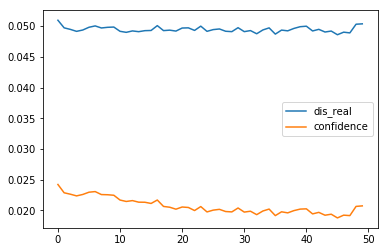

Generation 46  fitness : -22.494499241629054
#################################
Measured population fitness : 8s
population fitness : [ -22.24546665  -26.80465548  -36.08804624  -67.70722886  -49.25820676
 -117.05976276  -61.7072009   -32.58067984  -48.26235064  -45.16303782]
mean fit : -50.68766359528162
tensor([ 0.1201,  0.0821,  0.1266, -0.0181, -0.0324, -0.1710,  0.0159,  0.0911,
         0.1946,  0.2058, -0.5800,  0.1026,  0.0120,  0.1399, -0.6052,  0.2037,
        -0.1213,  0.1764,  0.1680, -0.0098], device='cuda:0')
tensor([0.0019, 0.0026, 0.0084, 0.0070, 0.0078, 0.0048, 0.0011, 0.0060, 0.0050,
        0.0069, 0.0069, 0.0054, 0.0044, 0.0072, 0.0054, 0.0058, 0.0065, 0.0053,
        0.0030, 0.0073], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


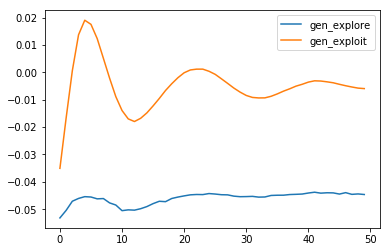

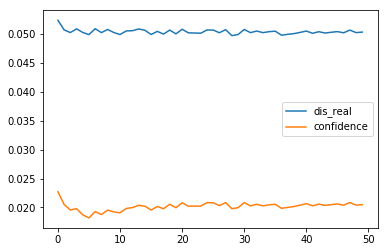

Generation 47  fitness : -22.245466647618084
#################################
Measured population fitness : 9s
population fitness : [ -30.18305599  -38.49742608  -32.82880212  -27.69983156  -46.57868287
  -22.16758977 -116.35135314  -42.41814559  -66.89366924  -30.84979087]
mean fit : -45.44683472164293
tensor([ 0.1603,  0.2062,  0.1342, -0.1645, -0.0184,  0.1677, -0.5803,  0.0908,
         0.1397,  0.0708,  0.2055,  0.0383,  0.1199,  0.0156, -0.1215, -0.1713,
         0.0038, -0.0101, -0.5744,  0.1178], device='cuda:0')
tensor([-0.0045, -0.0093, -0.0068, -0.0075, -0.0072, -0.0109, -0.0059, -0.0111,
        -0.0078, -0.0089, -0.0065, -0.0080, -0.0075, -0.0092, -0.0071, -0.0091,
        -0.0073, -0.0087, -0.0074, -0.0099],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


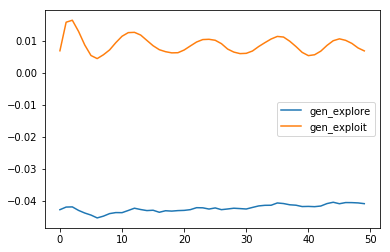

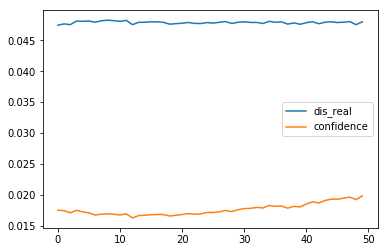

Generation 48  fitness : -22.167589765954727
#################################
Measured population fitness : 9s
population fitness : [-22.89648918 -36.41324251 -55.48408158 -22.79950473 -23.42273194
 -45.18157751 -66.75842798 -19.21763889 -24.66021419 -18.11118606]
mean fit : -33.494509457081904
tensor([ 0.0858, -0.0723, -0.5767, -0.1657,  0.2039,  0.1319,  0.2375,  0.1580,
         0.1832,  0.1374,  0.0131,  0.1935,  0.2283,  0.0685,  0.1986,  0.1978,
         0.0015,  0.0360,  0.1155, -0.1668], device='cuda:0')
tensor([0.0593, 0.0597, 0.0600, 0.0636, 0.0639, 0.0591, 0.0607, 0.0619, 0.0593,
        0.0533, 0.0594, 0.0574, 0.0627, 0.0601, 0.0612, 0.0633, 0.0580, 0.0556,
        0.0594, 0.0611], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


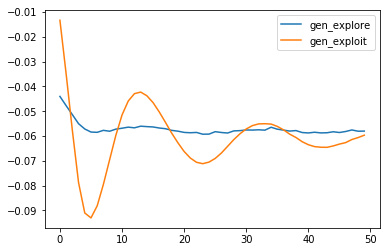

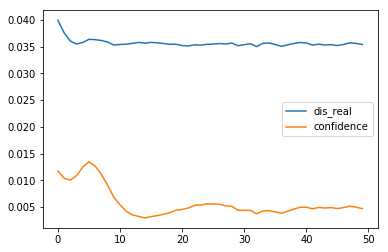

Generation 49  fitness : -18.111186055052563
#################################
Measured population fitness : 8s
population fitness : [-15.31867599 -44.09283599 -21.20800876 -22.59293932 -53.51347273
 -33.72880566 -96.38232438 -33.50496632 -31.45336482 -46.60414172]
mean fit : -39.83995356849904
tensor([ 0.0210,  0.1258,  0.2363,  0.1923,  0.0846,  0.0002,  0.1821,  0.1069,
        -0.1669,  0.1992,  0.2272,  0.2107, -0.0734,  0.2595,  0.1088,  0.1975,
        -0.4124, -0.0571,  0.1967,  0.0120], device='cuda:0')
tensor([0.0823, 0.0842, 0.0853, 0.0835, 0.0837, 0.0854, 0.0845, 0.0858, 0.0836,
        0.0850, 0.0760, 0.0820, 0.0750, 0.0841, 0.0757, 0.0871, 0.0847, 0.0842,
        0.0859, 0.0892], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


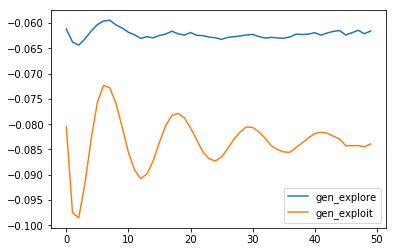

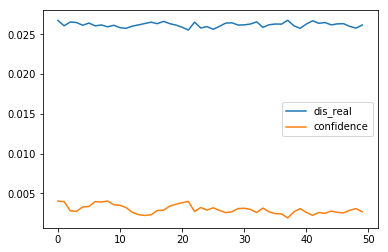

Generation 50  fitness : -15.318675985975302
#################################
Measured population fitness : 10s
population fitness : [-45.73798375 -55.0112333  -35.81373836 -25.5484151  -42.51757426
 -20.52664116 -50.6482615  -19.15019398 -26.95142704 -17.05186919]
mean fit : -33.89573376357303
tensor([ 0.1726,  0.2086,  0.1237,  0.1971,  0.1048,  0.2257,  0.0320, -0.0716,
         0.2574, -0.0354, -0.0019, -0.4144, -0.0591,  0.0053,  0.2142,  0.2430,
         0.0875,  0.1067,  0.1610,  0.0189], device='cuda:0')
tensor([0.0808, 0.0882, 0.0843, 0.0843, 0.0814, 0.0825, 0.0816, 0.0752, 0.0848,
        0.0638, 0.0746, 0.0561, 0.0825, 0.0823, 0.0842, 0.0821, 0.0733, 0.0838,
        0.0942, 0.0838], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


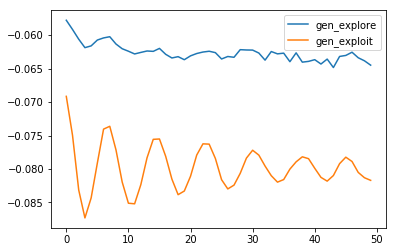

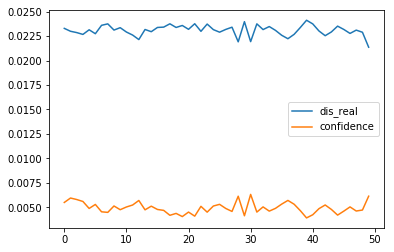

Generation 51  fitness : -17.051869189458543
#################################
Measured population fitness : 9s
population fitness : [-15.06228087 -42.18127379 -46.50202095 -14.48866842 -28.64399874
 -35.68909702 -42.44668761 -25.06937273 -18.18095646 -35.64407116]
mean fit : -30.390842773917694
tensor([ 0.0294,  0.0322,  0.1584,  0.2570,  0.0300,  0.1444,  0.2117,  0.2311,
         0.2405, -0.0379,  0.0850, -0.0036,  0.1701,  0.0864,  0.2617,  0.0027,
        -0.0741,  0.2231,  0.0860,  0.1740], device='cuda:0')
tensor([0.1176, 0.1134, 0.1132, 0.1155, 0.1139, 0.1149, 0.1107, 0.1156, 0.1093,
        0.1156, 0.1097, 0.1011, 0.1144, 0.1127, 0.1162, 0.1171, 0.1176, 0.1131,
        0.1153, 0.1172], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


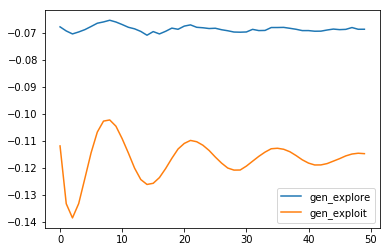

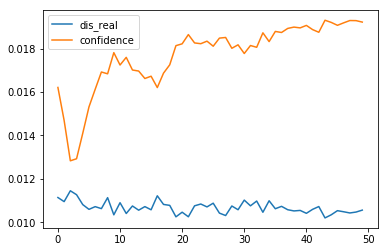

Generation 52  fitness : -14.488668416226917
#################################
Measured population fitness : 9s
population fitness : [-51.68445851 -55.02082901 -41.10758583 -26.23586068 -37.17471658
 -25.64687769 -24.78714449 -51.07344918 -52.7202742  -63.91543338]
mean fit : -42.936662954518454
tensor([ 0.2612,  0.2565,  0.0406, -0.1484, -0.0041,  0.0295,  0.1639, -0.0470,
         0.0859, -0.0747,  0.0732, -0.0420,  0.2306,  0.1759,  0.0317,  0.1439,
        -0.0556,  0.1736,  0.0855,  0.1688], device='cuda:0')
tensor([0.0789, 0.0777, 0.0789, 0.0775, 0.0722, 0.0766, 0.0776, 0.0801, 0.0765,
        0.0772, 0.0782, 0.0782, 0.0780, 0.0772, 0.0782, 0.0769, 0.0785, 0.0753,
        0.0784, 0.0777], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


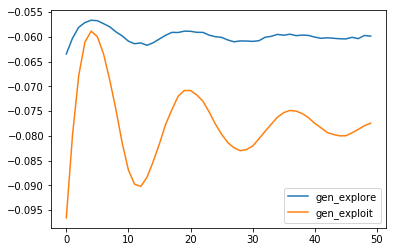

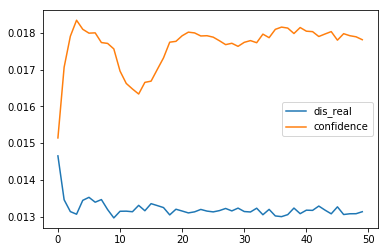

Generation 53  fitness : -24.787144486737887
#################################
Measured population fitness : 9s
population fitness : [-21.96271995 -18.23234077 -42.34355104 -29.95522467 -11.50833376
 -15.85511251 -43.95790803 -36.41675837 -35.63341414 -22.96346448]
mean fit : -27.882882772036776
tensor([ 0.2274,  0.0832,  0.0142,  0.0379,  0.0704,  0.1882, -0.0498,  0.1731,
         0.2832, -0.0447, -0.0584,  0.1965,  0.0276, -0.0775,  0.1660, -0.1512,
         0.1303,  0.0767,  0.1611,  0.2471], device='cuda:0')
tensor([0.0839, 0.0895, 0.0831, 0.0838, 0.0816, 0.0880, 0.0839, 0.0856, 0.0903,
        0.0827, 0.0843, 0.0826, 0.0844, 0.0836, 0.0850, 0.0853, 0.0868, 0.0896,
        0.0873, 0.0843], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


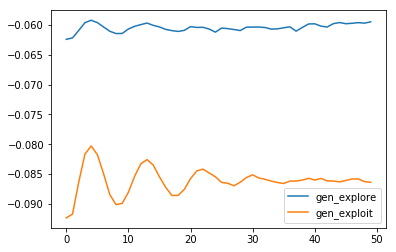

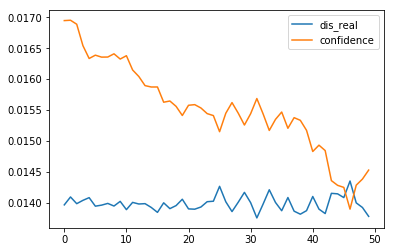

Generation 54  fitness : -11.508333758400106
#################################
Measured population fitness : 10s
population fitness : [-22.05473673 -40.65461314 -75.78147673 -29.21872571 -17.57260741
 -35.05135612 -25.52348126 -90.35090395 -49.35063097 -64.03445471]
mean fit : -44.9592986722006
tensor([ 0.1302,  0.2470,  0.1363,  0.1881,  0.2273,  0.1669,  0.2831,  0.0766,
         0.1964,  0.0879,  0.0275, -0.0306,  0.0415,  0.2328, -0.2496,  0.0831,
         0.0141, -0.3704,  0.1957, -0.1523], device='cuda:0')
tensor([0.0768, 0.0778, 0.0769, 0.0766, 0.0766, 0.0772, 0.0722, 0.0767, 0.0763,
        0.0761, 0.0767, 0.0765, 0.0765, 0.0773, 0.0775, 0.0762, 0.0764, 0.0775,
        0.0782, 0.0724], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


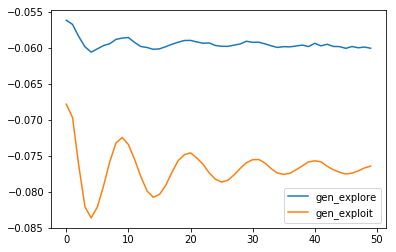

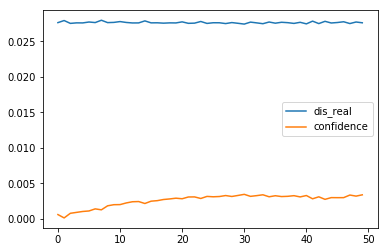

Generation 55  fitness : -17.572607412060247
#################################
Measured population fitness : 8s
population fitness : [-98.10595414 -14.6462615  -34.8136187  -28.48752458 -22.38533358
 -49.73476312 -67.76517607 -41.10272482 -34.83435602 -51.72104554]
mean fit : -44.35967580680701
tensor([-0.0308,  0.1421,  0.1667,  0.1361, -0.3706,  0.0413, -0.4348,  0.0897,
         0.1955, -0.1834,  0.2326, -0.2498,  0.2569,  0.0895,  0.0376, -0.0504,
         0.0877, -0.1525,  0.1927, -0.0339], device='cuda:0')
tensor([0.0056, 0.0051, 0.0053, 0.0054, 0.0056, 0.0052, 0.0049, 0.0050, 0.0055,
        0.0048, 0.0053, 0.0053, 0.0055, 0.0061, 0.0050, 0.0064, 0.0051, 0.0030,
        0.0054, 0.0048], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


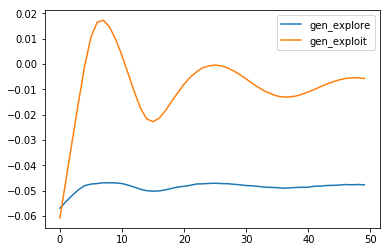

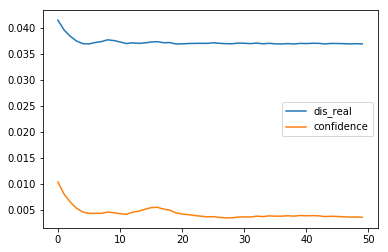

Generation 56  fitness : -14.64626150444208
#################################
Measured population fitness : 7s
population fitness : [-101.20541245  -51.86179071  -62.36449486  -28.45388954  -52.77672035
  -95.26305043  -14.13084155  -25.17971107  -21.77232948  -48.33512532]
mean fit : -50.1343365753545
tensor([ 0.0904,  0.2575, -0.1380, -0.0509, -0.4342,  0.1431, -0.0498, -0.4106,
        -0.0585, -0.0333, -0.0217,  0.2618,  0.0902, -0.4599,  0.0382,  0.1702,
         0.1428, -0.1827,  0.1985,  0.1934], device='cuda:0')
tensor([-0.0121, -0.0133, -0.0137, -0.0104, -0.0141, -0.0112, -0.0115, -0.0109,
        -0.0133, -0.0153, -0.0112, -0.0110, -0.0114, -0.0138, -0.0133, -0.0117,
        -0.0106, -0.0149, -0.0134, -0.0147],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


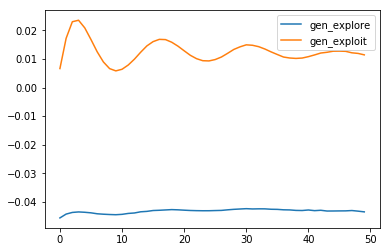

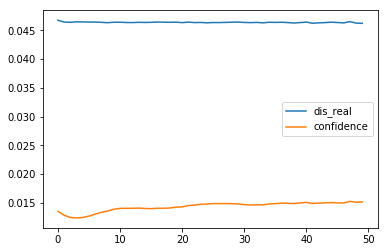

Generation 57  fitness : -14.13084154581105
#################################
Measured population fitness : 8s
population fitness : [ -20.68142498  -24.39974188  -43.42787701 -110.20381042  -18.36155727
  -19.59300928  -46.84052881 -111.48996983  -19.86126129  -52.15688098]
mean fit : -46.701606175259215
tensor([-0.5450, -0.4597, -0.0584,  0.2619,  0.1432, -0.5343,  0.1768,  0.2269,
        -0.0216, -0.1378,  0.2076, -0.0532,  0.2144, -0.0508, -0.0092,  0.0191,
         0.2167, -0.4105,  0.1704,  0.1986], device='cuda:0')
tensor([-0.0231, -0.0241, -0.0232, -0.0255, -0.0225, -0.0223, -0.0238, -0.0219,
        -0.0222, -0.0231, -0.0221, -0.0224, -0.0223, -0.0239, -0.0230, -0.0219,
        -0.0221, -0.0241, -0.0231, -0.0246],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


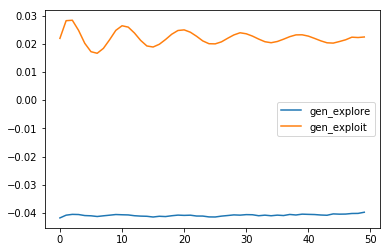

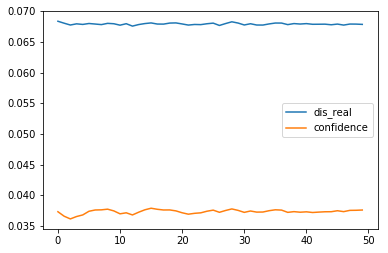

Generation 58  fitness : -18.361557271326586
#################################
Measured population fitness : 7s
population fitness : [ -21.17519543 -110.83842264  -39.15910283  -27.20930163  -36.08782112
 -100.8926011   -36.30361368  -27.1761413   -18.33281797  -32.11628576]
mean fit : -44.92913034824895
tensor([ 0.0798,  0.2165,  0.0190,  0.2143,  0.1537, -0.0093,  0.2270, -0.0533,
         0.1534, -0.5451, -0.5344,  0.1767, -0.4573,  0.0544,  0.2034,  0.2075,
         0.0780, -0.5397,  0.2267,  0.1128], device='cuda:0')
tensor([-0.0062, -0.0007, -0.0012, -0.0016, -0.0015, -0.0005, -0.0036, -0.0061,
        -0.0004, -0.0011, -0.0015, -0.0016, -0.0019,  0.0002, -0.0002, -0.0013,
        -0.0012, -0.0022, -0.0005, -0.0002],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


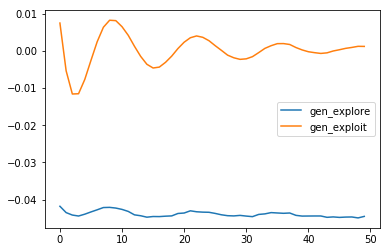

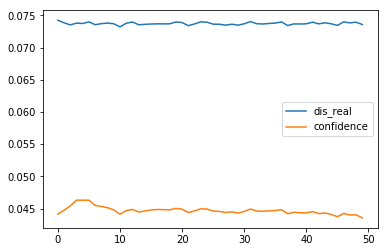

Generation 59  fitness : -18.332817973611142
#################################
Measured population fitness : 8s
population fitness : [ -62.88077268 -109.07985733  -24.26320793  -32.39374357  -35.47624657
  -50.92388178  -94.37565034  -20.54263012  -20.80812799  -30.97028685]
mean fit : -48.17144051532681
tensor([ 0.2068,  0.2273,  0.0802, -0.4569, -0.5394, -0.1419,  0.1131,  0.0784,
         0.0547, -0.0428,  0.1226,  0.2090,  0.2038,  0.0852,  0.1538,  0.1782,
         0.1540,  0.1108, -0.4029, -0.5248], device='cuda:0')
tensor([-0.0060, -0.0067, -0.0065, -0.0053, -0.0059, -0.0051, -0.0063, -0.0078,
        -0.0063, -0.0054, -0.0067, -0.0050, -0.0057, -0.0060, -0.0062, -0.0058,
        -0.0067, -0.0067, -0.0061, -0.0086],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 10s
Evolved : 0s


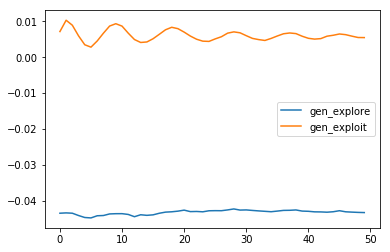

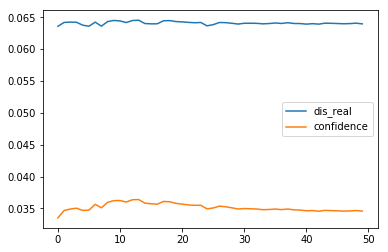

Generation 60  fitness : -20.542630115820117
#################################
Measured population fitness : 8s
population fitness : [ -14.9720115  -104.7744766   -58.06475444  -66.15104848  -25.29200325
  -21.17445624  -16.4637587   -36.97521558  -20.52621841  -23.07022886]
mean fit : -38.746417207108465
tensor([-0.4900,  0.1772,  0.2059,  0.2419,  0.1871,  0.1098,  0.2082, -0.0437,
         0.0843,  0.2028, -0.1699, -0.4039,  0.2542,  0.1687,  0.1216, -0.5257,
         0.0719,  0.2081, -0.1428, -0.1029], device='cuda:0')
tensor([0.0198, 0.0182, 0.0173, 0.0158, 0.0177, 0.0160, 0.0162, 0.0186, 0.0164,
        0.0155, 0.0176, 0.0193, 0.0169, 0.0182, 0.0186, 0.0176, 0.0154, 0.0165,
        0.0135, 0.0156], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


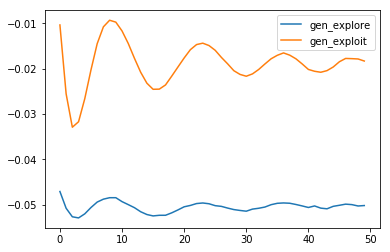

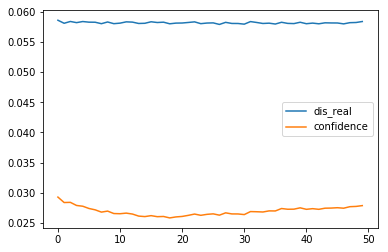

Generation 61  fitness : -14.972011499430996
#################################
Measured population fitness : 11s
population fitness : [-17.5119626  -32.22561093 -54.68778698 -36.05415435 -25.80480485
 -41.21761648 -30.884346   -31.55530945 -40.78151983 -19.73097281]
mean fit : -33.04540842936645
tensor([ 0.1628,  0.2402, -0.1716,  0.1670,  0.2065,  0.1095,  0.2315,  0.1151,
        -0.4917, -0.1046,  0.2131,  0.1854, -0.0766,  0.2011,  0.0386,  0.2525,
         0.0702,  0.0350,  0.1207,  0.0778], device='cuda:0')
tensor([0.0776, 0.0788, 0.0754, 0.0751, 0.0765, 0.0765, 0.0763, 0.0760, 0.0787,
        0.0754, 0.0757, 0.0765, 0.0768, 0.0748, 0.0778, 0.0779, 0.0762, 0.0755,
        0.0754, 0.0744], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


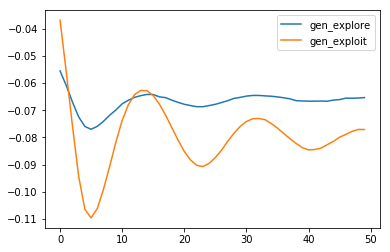

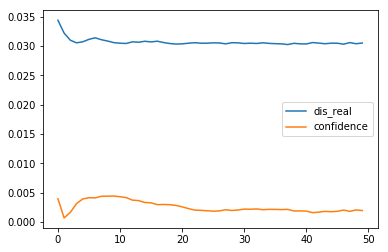

Generation 62  fitness : -17.511962602278977
#################################
Measured population fitness : 11s
population fitness : [-44.3373608  -35.43549323 -57.93193476 -38.66353283 -71.38036224
 -70.028959   -27.49465672 -45.62114529 -15.66820275 -51.52481961]
mean fit : -45.808646722668655
tensor([ 0.1488, -0.2037, -0.0014,  0.0779,  0.2315,  0.0387,  0.2468,  0.2131,
         0.1207,  0.1628, -0.0504,  0.0562,  0.1096,  0.0351, -0.0766, -0.2149,
        -0.1035,  0.0092,  0.0830,  0.1152], device='cuda:0')
tensor([0.0480, 0.0498, 0.0474, 0.0482, 0.0481, 0.0478, 0.0490, 0.0467, 0.0474,
        0.0466, 0.0497, 0.0510, 0.0502, 0.0482, 0.0502, 0.0480, 0.0490, 0.0509,
        0.0491, 0.0476], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


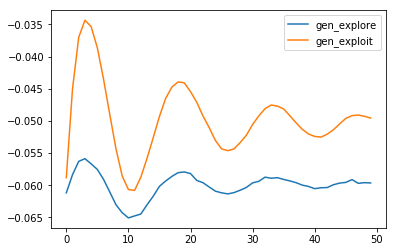

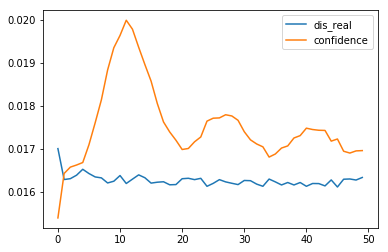

Generation 63  fitness : -15.66820274700423
#################################
Measured population fitness : 10s
population fitness : [-33.9344509  -15.60928166 -16.4149394  -50.25794317 -20.40359349
 -27.70237459 -29.62937925 -33.59792755 -43.28933099 -32.6356275 ]
mean fit : -30.3474848508516
tensor([-0.1054, -0.0523,  0.1042,  0.2454,  0.1451,  0.0810,  0.0543,  0.0073,
         0.0963,  0.0935,  0.1292,  0.2056,  0.1468,  0.2449, -0.2169, -0.0034,
        -0.0418,  0.0159,  0.2387, -0.2057], device='cuda:0')
tensor([0.0594, 0.0562, 0.0611, 0.0617, 0.0549, 0.0583, 0.0594, 0.0577, 0.0595,
        0.0610, 0.0578, 0.0583, 0.0577, 0.0554, 0.0594, 0.0603, 0.0589, 0.0585,
        0.0630, 0.0578], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


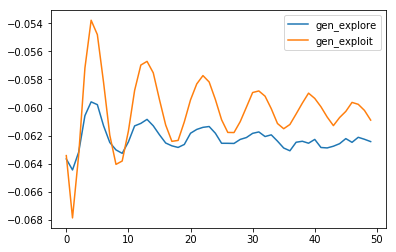

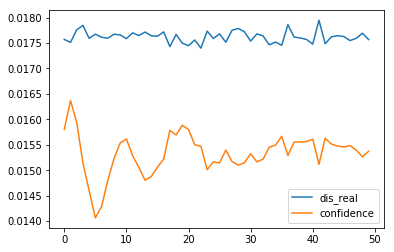

Generation 64  fitness : -15.609281664572043
#################################
Measured population fitness : 10s
population fitness : [-29.56697389 -52.8246554  -23.27028753 -28.47843672 -32.17232949
 -43.20026866 -40.61849882 -43.62405017 -16.6978809  -39.14024233]
mean fit : -34.95936239018878
tensor([ 0.1284,  0.0922, -0.0644,  0.0950,  0.0368,  0.1278,  0.0119,  0.1374,
         0.2043,  0.2440,  0.1438,  0.1029, -0.0431,  0.0154,  0.2350,  0.2374,
         0.1068,  0.0146,  0.0490,  0.1806], device='cuda:0')
tensor([0.1083, 0.1029, 0.1021, 0.1034, 0.1060, 0.1041, 0.1055, 0.1011, 0.1080,
        0.1046, 0.1084, 0.1011, 0.1038, 0.1033, 0.1056, 0.1039, 0.1049, 0.1042,
        0.1030, 0.1054], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


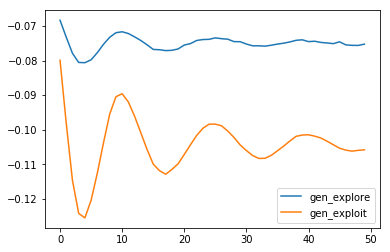

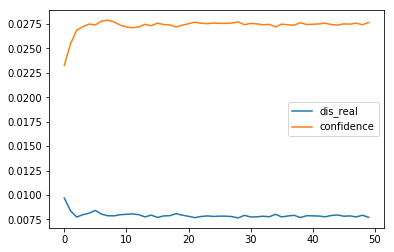

Generation 65  fitness : -16.697880898292016
#################################
Measured population fitness : 11s
population fitness : [-30.80316039 -28.46030523 -13.17226505 -72.53848195 -22.98234308
 -42.97034926 -23.62585139 -27.36524697 -54.0037395  -47.82191657]
mean fit : -36.374365938905996
tensor([ 0.1057,  0.0479,  0.0162, -0.2289,  0.1363,  0.1273,  0.2339, -0.0655,
         0.1795,  0.1364, -0.0753, -0.0240,  0.1170,  0.1818,  0.0143,  0.0108,
         0.1765,  0.2632,  0.1455,  0.0357], device='cuda:0')
tensor([0.0742, 0.0735, 0.0737, 0.0764, 0.0750, 0.0744, 0.0734, 0.0780, 0.0726,
        0.0771, 0.0762, 0.0785, 0.0748, 0.0759, 0.0751, 0.0737, 0.0749, 0.0779,
        0.0779, 0.0780], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


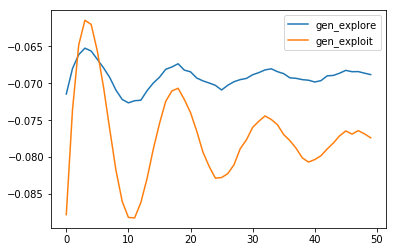

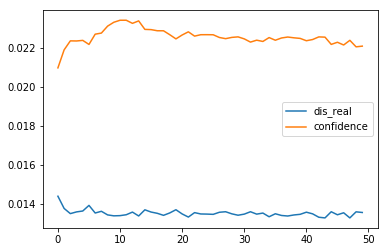

Generation 66  fitness : -13.172265051257503
#################################
Measured population fitness : 10s
population fitness : [-35.50852675 -39.37960773 -27.55996769 -28.25869628 -49.32998866
 -62.44462345 -39.84793997 -33.9405525  -44.45147934 -44.10998585]
mean fit : -40.48313682065385
tensor([-0.0246,  0.1376,  0.1359, -0.0371,  0.0062,  0.1165,  0.1450,  0.1434,
         0.0156,  0.0034,  0.0905, -0.2294,  0.0415, -0.0758,  0.1813,  0.0775,
         0.2626,  0.1760, -0.1458,  0.0454], device='cuda:0')
tensor([0.0521, 0.0525, 0.0529, 0.0540, 0.0525, 0.0531, 0.0521, 0.0515, 0.0535,
        0.0536, 0.0532, 0.0529, 0.0527, 0.0517, 0.0515, 0.0518, 0.0529, 0.0526,
        0.0529, 0.0537], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


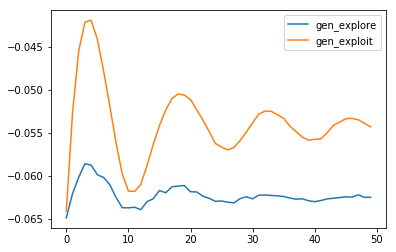

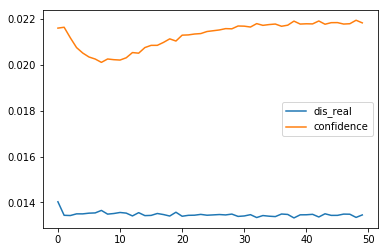

Generation 67  fitness : -27.55996769051103
#################################
Measured population fitness : 10s
population fitness : [-44.44126091 -32.74744214 -42.86065005 -42.32002595 -46.38819795
 -42.92340204 -32.88641698 -43.00526289 -29.72288898 -39.75843712]
mean fit : -39.70539850056515
tensor([-0.0133,  0.0027,  0.0448,  0.0416,  0.0028,  0.0204,  0.1369,  0.1248,
         0.0899,  0.0154,  0.0159,  0.0769, -0.0377,  0.0147,  0.0997, -0.1464,
         0.0986,  0.0056,  0.1427,  0.0409], device='cuda:0')
tensor([0.0382, 0.0388, 0.0378, 0.0381, 0.0383, 0.0377, 0.0389, 0.0383, 0.0380,
        0.0380, 0.0381, 0.0386, 0.0382, 0.0392, 0.0379, 0.0385, 0.0375, 0.0379,
        0.0382, 0.0388], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


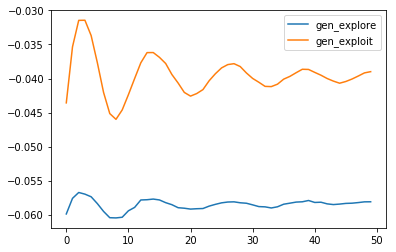

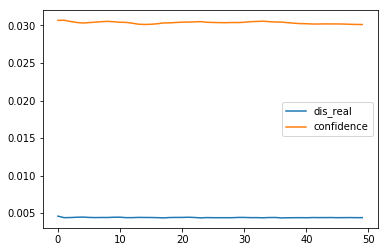

Generation 68  fitness : -29.72288897670843
#################################
Measured population fitness : 10s
population fitness : [-47.32018541 -27.27132586 -26.88857827 -30.89580489 -26.66653758
 -40.26687582 -70.17405114 -45.95902665 -64.55389766 -50.70598535]
mean fit : -43.07022686142476
tensor([-0.0135,  0.0414,  0.0202,  0.1481, -0.0493, -0.2107,  0.1499,  0.1246,
         0.0152, -0.0212, -0.1641,  0.0372, -0.0100,  0.0157,  0.0145,  0.0995,
         0.1449,  0.1149,  0.0026,  0.0984], device='cuda:0')
tensor([0.0267, 0.0281, 0.0263, 0.0269, 0.0258, 0.0259, 0.0277, 0.0286, 0.0282,
        0.0298, 0.0263, 0.0274, 0.0288, 0.0269, 0.0277, 0.0274, 0.0267, 0.0316,
        0.0282, 0.0259], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


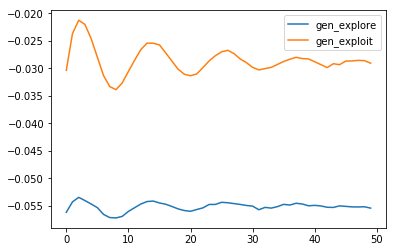

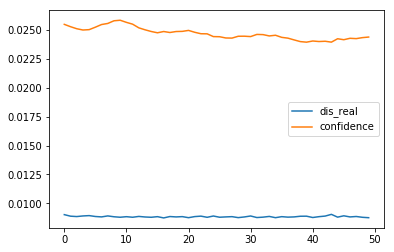

Generation 69  fitness : -26.66653757659746
#################################
Measured population fitness : 10s
population fitness : [-50.48224216 -26.77652023 -52.70365163 -50.52848896 -30.63498031
 -43.50905281 -38.86432412 -56.49259268 -36.5647856  -52.24507876]
mean fit : -43.880171727969206
tensor([ 0.0102, -0.0974,  0.1480,  0.1148, -0.0479,  0.0371, -0.0494,  0.1498,
         0.1448, -0.2108, -0.0622, -0.0213,  0.0487,  0.0678,  0.1489,  0.1169,
        -0.0476, -0.0660, -0.0101, -0.1642], device='cuda:0')
tensor([0.0078, 0.0084, 0.0109, 0.0119, 0.0098, 0.0084, 0.0128, 0.0109, 0.0083,
        0.0093, 0.0123, 0.0098, 0.0094, 0.0112, 0.0094, 0.0077, 0.0083, 0.0119,
        0.0088, 0.0087], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


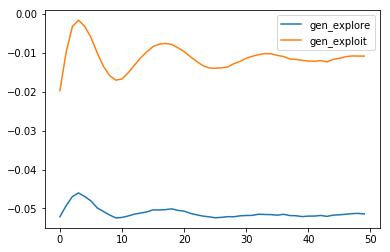

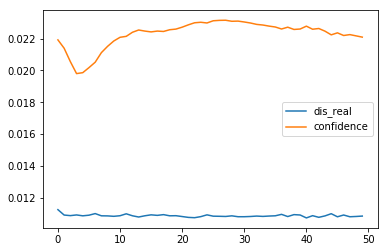

Generation 70  fitness : -26.776520234353956
#################################
Measured population fitness : 11s
population fitness : [-33.18805698 -31.75942209 -27.50903309 -28.51547078 -62.36213479
 -46.19879102 -44.12298257 -44.53650606 -48.23949975 -58.99653786]
mean fit : -42.5428434999153
tensor([ 0.0675,  0.1342,  0.0100,  0.1487, -0.0662, -0.1463,  0.0955,  0.1426,
         0.0485, -0.0976,  0.1167, -0.0624, -0.0292,  0.0049, -0.0478, -0.1184,
         0.1074,  0.0015, -0.0482, -0.0123], device='cuda:0')
tensor([0.0104, 0.0124, 0.0142, 0.0098, 0.0121, 0.0095, 0.0095, 0.0122, 0.0120,
        0.0121, 0.0116, 0.0138, 0.0126, 0.0144, 0.0135, 0.0098, 0.0135, 0.0099,
        0.0122, 0.0134], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


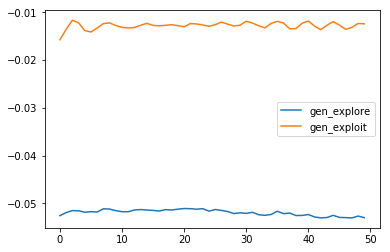

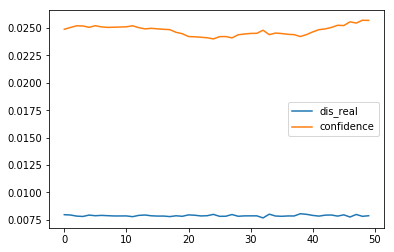

Generation 71  fitness : -27.509033087328095
#################################
Measured population fitness : 11s
population fitness : [-61.20792113 -36.42670423 -47.82334    -37.71688235 -36.99883277
 -39.52863174 -36.77105741 -22.13329718 -37.69259338 -42.25995142]
mean fit : -39.85592116107293
tensor([ 0.0424,  0.1866,  0.1068,  0.0576,  0.0950,  0.0653,  0.0574,  0.0043,
        -0.1373,  0.0634, -0.0298, -0.1468,  0.0009,  0.1337,  0.0198, -0.0129,
        -0.1189,  0.0681, -0.0263,  0.1420], device='cuda:0')
tensor([0.0292, 0.0283, 0.0277, 0.0282, 0.0263, 0.0298, 0.0277, 0.0260, 0.0302,
        0.0265, 0.0293, 0.0263, 0.0297, 0.0286, 0.0265, 0.0275, 0.0266, 0.0272,
        0.0291, 0.0287], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


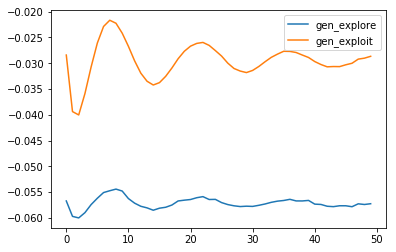

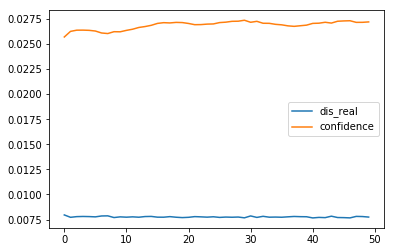

Generation 72  fitness : -22.133297179352724
#################################
Measured population fitness : 10s
population fitness : [-35.63948605 -44.83465772 -36.55541834 -37.98192651 -59.20015116
 -41.64062884 -29.78777415 -52.27320996 -40.51161619 -37.01665431]
mean fit : -41.544152322853144
tensor([ 0.0421,  0.0573,  0.0194,  0.0339, -0.1376,  0.0549, -0.1210, -0.0267,
         0.0678,  0.0667,  0.0571,  0.1862,  0.0629,  0.0743, -0.0019,  0.1228,
         0.0649,  0.0630, -0.0636,  0.0246], device='cuda:0')
tensor([0.0322, 0.0324, 0.0319, 0.0307, 0.0327, 0.0323, 0.0321, 0.0311, 0.0313,
        0.0324, 0.0326, 0.0325, 0.0319, 0.0314, 0.0312, 0.0309, 0.0316, 0.0327,
        0.0326, 0.0311], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


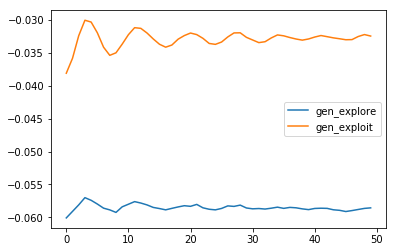

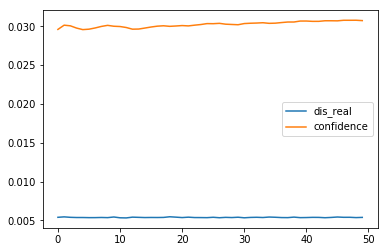

Generation 73  fitness : -29.78777415150967
#################################
Measured population fitness : 10s
population fitness : [-65.34029288 -37.66260872 -26.18160368 -55.30182005 -30.33739303
 -44.98714288 -41.85735282 -69.99523089 -49.21263552 -36.54608319]
mean fit : -45.74221636635378
tensor([ 0.0744,  0.0340,  0.0630, -0.0885,  0.0247, -0.1208,  0.1528, -0.0634,
         0.1184, -0.0031, -0.0018, -0.0381,  0.0550,  0.1229, -0.2103,  0.0577,
         0.0669,  0.0229, -0.1717,  0.0668], device='cuda:0')
tensor([0.0108, 0.0095, 0.0086, 0.0113, 0.0078, 0.0082, 0.0097, 0.0096, 0.0083,
        0.0083, 0.0096, 0.0084, 0.0086, 0.0087, 0.0090, 0.0078, 0.0089, 0.0079,
        0.0110, 0.0095], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


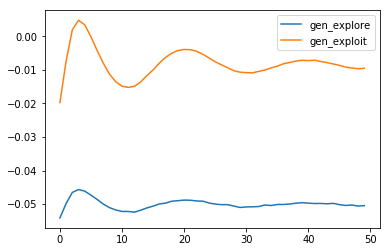

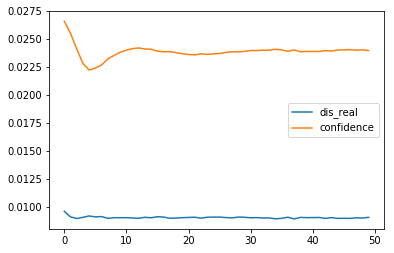

Generation 74  fitness : -26.181603684186847
#################################
Measured population fitness : 9s
population fitness : [-97.25417118 -53.48499794 -51.7904576  -68.58534428 -36.12425844
 -44.0335493  -49.83350869 -56.03370027 -27.38649394 -44.88864153]
mean fit : -52.941512316432146
tensor([ 0.0058,  0.0713, -0.0021,  0.1537, -0.1977,  0.0678, -0.1708,  0.0586,
         0.1193,  0.0238, -0.0585, -0.0726, -0.0013, -0.4353, -0.0372, -0.0937,
        -0.2094, -0.0876, -0.0423,  0.1437], device='cuda:0')
tensor([-0.0379, -0.0376, -0.0396, -0.0367, -0.0368, -0.0364, -0.0366, -0.0390,
        -0.0365, -0.0370, -0.0368, -0.0376, -0.0383, -0.0379, -0.0359, -0.0370,
        -0.0365, -0.0381, -0.0368, -0.0395],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


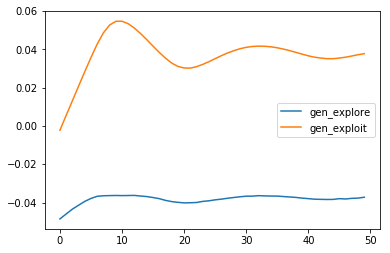

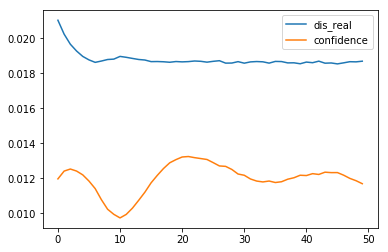

Generation 75  fitness : -27.38649393765916
#################################
Measured population fitness : 9s
population fitness : [ -35.71244251  -34.2611345   -60.78305694  -51.89777959  -57.28211849
  -54.03432872  -53.08657523  -44.8412699  -100.49656971  -63.52116854]
mean fit : -55.591644413982806
tensor([ 0.0003, -0.1546, -0.4610,  0.0725, -0.0582,  0.0070, -0.0001, -0.1028,
        -0.1319, -0.0759,  0.1449, -0.0411, -0.0714, -0.0925, -0.4341,  0.0759,
         0.0879, -0.1965, -0.0681, -0.0573], device='cuda:0')
tensor([-0.0792, -0.0792, -0.0802, -0.0809, -0.0795, -0.0794, -0.0797, -0.0796,
        -0.0794, -0.0797, -0.0801, -0.0793, -0.0794, -0.0804, -0.0798, -0.0799,
        -0.0796, -0.0799, -0.0798, -0.0797],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


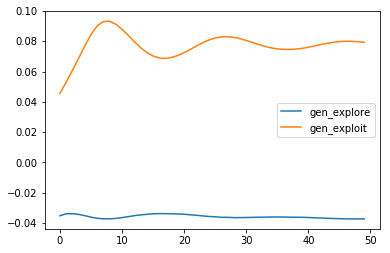

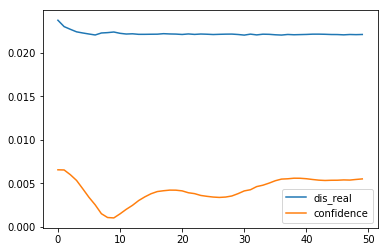

Generation 76  fitness : -34.26113450472371
#################################
Measured population fitness : 9s
population fitness : [-61.23918886 -62.01642143 -51.98046101 -34.8397036  -96.02186312
 -39.76653837 -71.19864402 -51.79338147 -56.87799939 -65.5122813 ]
mean fit : -59.1246482579842
tensor([-0.1406, -0.0567, -0.4595, -0.0665, -0.1303, -0.0558, -0.0574,  0.0847,
        -0.1695,  0.0895, -0.2167, -0.1530, -0.1013,  0.0439, -0.4224,  0.0775,
        -0.0744, -0.0980,  0.0018, -0.1341], device='cuda:0')
tensor([-0.1031, -0.1026, -0.1027, -0.1024, -0.1031, -0.1035, -0.1031, -0.1028,
        -0.1023, -0.1024, -0.1029, -0.1035, -0.1027, -0.1029, -0.1028, -0.1035,
        -0.1027, -0.1024, -0.1022, -0.1029],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


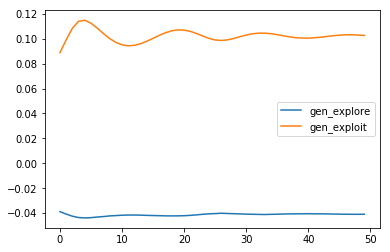

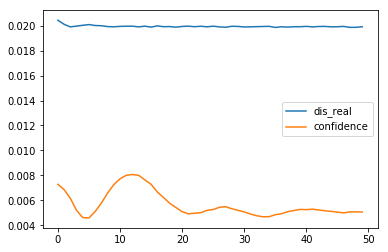

Generation 77  fitness : -34.839703598138584
#################################
Measured population fitness : 8s
population fitness : [ -61.43058028  -49.67275449 -101.91481736  -34.54174731 -101.26758921
  -70.90244514  -39.23347584  -42.47733502  -48.63409517  -32.82147008]
mean fit : -58.28963099020884
tensor([-0.4210, -0.0368, -0.0544,  0.0497, -0.2128,  0.0228, -0.2152, -0.0560,
        -0.1681,  0.0886,  0.0861, -0.4645, -0.0966, -0.4698,  0.0453, -0.1391,
        -0.1343, -0.0282, -0.1327,  0.1028], device='cuda:0')
tensor([-0.1110, -0.1131, -0.1118, -0.1116, -0.1115, -0.1119, -0.1121, -0.1108,
        -0.1122, -0.1127, -0.1122, -0.1116, -0.1120, -0.1118, -0.1108, -0.1115,
        -0.1115, -0.1116, -0.1124, -0.1112],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


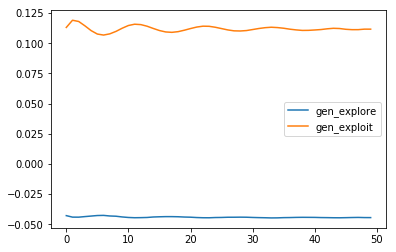

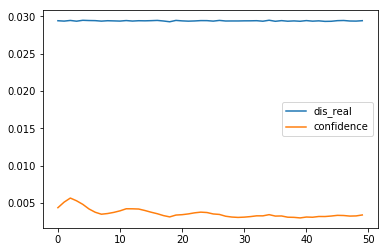

Generation 78  fitness : -32.82147008243938
#################################
Measured population fitness : 8s
population fitness : [ -63.69131259  -67.63345814  -99.44023532 -121.0202529   -67.81028662
  -55.72104502  -63.76406031  -42.13876401  -88.61235129  -62.11306456]
mean fit : -73.19448307551603
tensor([-0.4464, -0.3566, -0.0840,  0.1058, -0.1501, -0.4669, -0.1507, -0.0339,
        -0.1314,  0.0257, -0.1842, -0.1370, -0.4615, -0.1828,  0.0915, -0.6252,
        -0.0253,  0.0285, -0.2099,  0.0526], device='cuda:0')
tensor([-0.1680, -0.1683, -0.1681, -0.1681, -0.1682, -0.1696, -0.1693, -0.1686,
        -0.1687, -0.1691, -0.1686, -0.1687, -0.1684, -0.1695, -0.1685, -0.1688,
        -0.1686, -0.1687, -0.1686, -0.1687],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


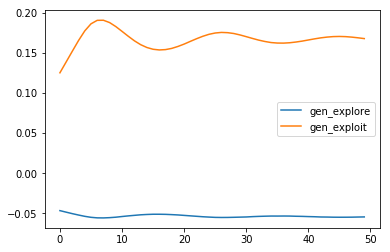

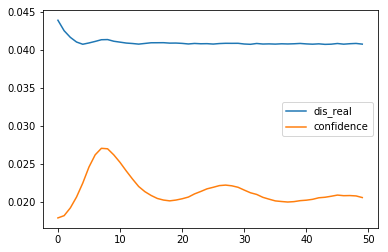

Generation 79  fitness : -42.138764011346886
#################################
Measured population fitness : 8s
population fitness : [ -52.57192204  -65.41430965  -73.41886476  -69.83425485 -136.52358275
  -24.63605117  -76.03504939  -77.49391371  -63.33688702  -95.26087637]
mean fit : -73.45257117321235
tensor([-0.1320,  0.0288, -0.1660, -0.2394, -0.2283, -0.0504, -0.4058, -0.1813,
        -0.6871, -0.2085, -0.1646, -0.5695,  0.1615, -0.1227, -0.1353, -0.1478,
        -0.3742, -0.3237, -0.1347, -0.0743], device='cuda:0')
tensor([-0.2073, -0.2066, -0.2071, -0.2063, -0.2064, -0.2060, -0.2062, -0.2071,
        -0.2069, -0.2072, -0.2077, -0.2066, -0.2076, -0.2068, -0.2069, -0.2087,
        -0.2071, -0.2073, -0.2075, -0.2069],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


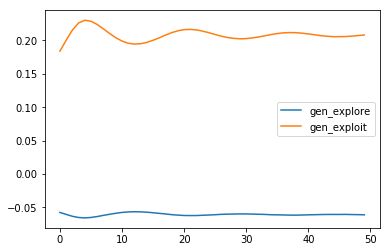

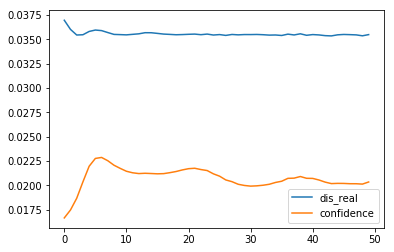

Generation 80  fitness : -24.636051173963327
#################################
Measured population fitness : 8s
population fitness : [ -74.25000783 -117.00159092  -47.02600704  -72.27623975  -70.63839391
 -119.09309605  -66.28079806 -108.92457087  -77.26161242  -64.8220972 ]
mean fit : -81.75744140415966
tensor([-0.1965, -0.2360, -0.1399, -0.1510, -0.1840, -0.2250, -0.2051, -0.5516,
        -0.1779, -0.2343, -0.5357,  0.1649, -0.0050, -0.3708, -0.1444, -0.2114,
        -0.4744, -0.0470, -0.6838, -0.1287], device='cuda:0')
tensor([-0.2352, -0.2373, -0.2356, -0.2348, -0.2349, -0.2343, -0.2365, -0.2357,
        -0.2369, -0.2376, -0.2373, -0.2365, -0.2355, -0.2354, -0.2364, -0.2347,
        -0.2350, -0.2362, -0.2361, -0.2367],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


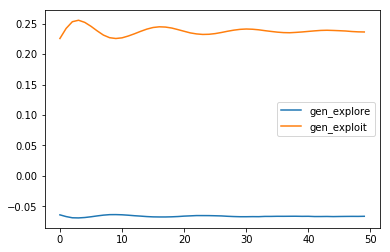

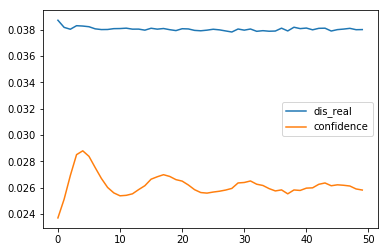

Generation 81  fitness : -47.02600703668456
#################################
Measured population fitness : 8s
population fitness : [ -67.97459547 -116.99783728  -69.60533736  -44.39919748  -74.6074945
  -79.49240115  -78.50114914 -122.11496259  -43.23790004 -108.59027222]
mean fit : -80.55211472179792
tensor([-0.5325, -0.1809, -0.1731, -0.2083, -0.5484, -0.2110, -0.1933, -0.4713,
        -0.5713,  0.0181, -0.2311, -0.1607, -0.1368, -0.2405, -0.5325, -0.4687,
        -0.1478, -0.0018, -0.2480,  0.0269], device='cuda:0')
tensor([-0.2608, -0.2621, -0.2612, -0.2628, -0.2634, -0.2591, -0.2580, -0.2607,
        -0.2612, -0.2591, -0.2586, -0.2587, -0.2624, -0.2637, -0.2587, -0.2577,
        -0.2590, -0.2624, -0.2590, -0.2634],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


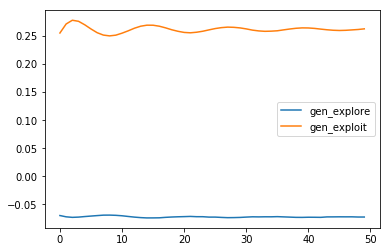

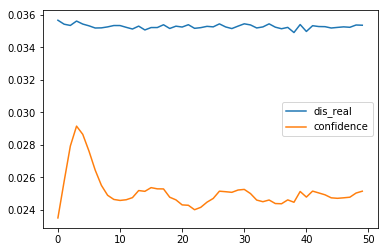

Generation 82  fitness : -43.23790003501904
#################################
Measured population fitness : 7s
population fitness : [ -74.0618596   -71.69995713  -65.36843373 -120.23454945  -73.66542529
  -70.22703266 -101.65069423 -118.8489909   -79.56763182  -42.97581938]
mean fit : -81.83003941916893
tensor([-0.1746, -0.1698, -0.5293, -0.2006, -0.1857, -0.4129, -0.2373, -0.2036,
        -0.4655,  0.0321, -0.5681, -0.1575, -0.2078,  0.0301, -0.5538, -0.1377,
        -0.5433,  0.0213, -0.2448, -0.2454], device='cuda:0')
tensor([-0.2588, -0.2550, -0.2586, -0.2582, -0.2590, -0.2581, -0.2609, -0.2566,
        -0.2598, -0.2565, -0.2551, -0.2581, -0.2582, -0.2582, -0.2545, -0.2547,
        -0.2547, -0.2549, -0.2544, -0.2591],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


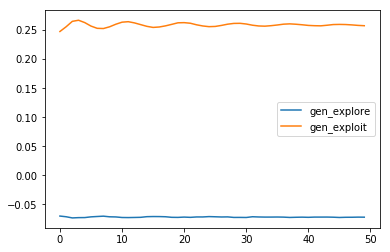

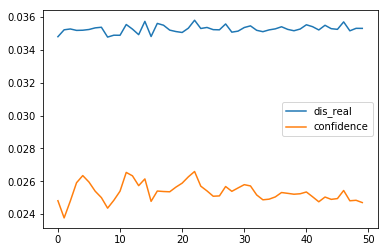

Generation 83  fitness : -42.97581937911918
#################################
Measured population fitness : 6s
population fitness : [ -35.47896796  -78.96577729 -110.66866951 -107.05856247  -47.10764537
 -111.71462817 -118.52912894  -83.97035351 -132.06287373  -76.2512456 ]
mean fit : -90.18078525740489
tensor([-0.4774,  0.0929, -0.2370, -0.2164, -0.1819, -0.5500,  0.0360, -0.4853,
        -0.2749, -0.4090,  0.0047, -0.4500, -0.1707, -0.5370, -0.2415, -0.1338,
        -0.6397, -0.1998, -0.1968, -0.5395], device='cuda:0')
tensor([-0.2895, -0.2929, -0.2899, -0.2934, -0.2855, -0.2887, -0.2917, -0.2894,
        -0.2893, -0.2881, -0.2858, -0.2936, -0.2920, -0.2902, -0.2898, -0.2880,
        -0.2897, -0.2884, -0.2849, -0.2904],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


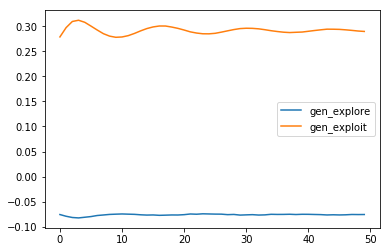

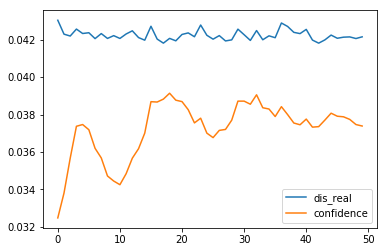

Generation 84  fitness : -35.47896796199716
#################################
Measured population fitness : 6s
population fitness : [ -72.88996857 -130.87350949 -110.05032393 -111.3996879   -59.33970099
  -93.59465592  -55.82601957 -105.22388236  -74.58954663 -130.44447865]
mean fit : -94.42317740046126
tensor([-0.3437, -0.0573, -0.2122,  0.0970, -0.1867, -0.0839, -0.4320, -0.2708,
        -0.5329, -0.4686, -0.1996, -0.6265, -0.4812,  0.0088, -0.6355, -0.4459,
        -0.4732, -0.6232, -0.4788, -0.2328], device='cuda:0')
tensor([-0.3388, -0.3372, -0.3385, -0.3347, -0.3360, -0.3375, -0.3348, -0.3367,
        -0.3358, -0.3364, -0.3371, -0.3341, -0.3331, -0.3346, -0.3349, -0.3380,
        -0.3374, -0.3330, -0.3379, -0.3338],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


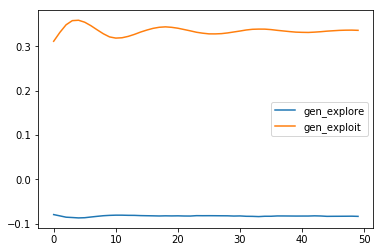

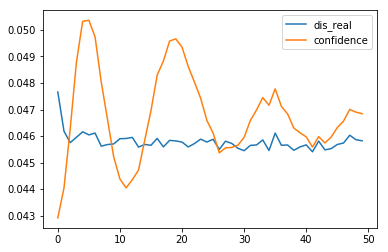

Generation 85  fitness : -55.826019566104776
#################################
Measured population fitness : 3s
population fitness : [-115.50607575 -108.5268019  -116.08478241  -84.88764923 -111.03691199
 -138.59360968 -114.96516596 -124.60849071  -51.60743056 -100.88388189]
mean fit : -106.67008000883877
tensor([-0.1788, -0.4449, -0.4636, -0.2683, -0.4562, -0.0198, -0.5013, -0.4663,
        -0.0513, -0.4970, -0.3334, -0.5650, -0.4202, -0.0776, -0.1914, -0.6117,
        -0.4929, -0.3878, -0.6085, -0.6694], device='cuda:0')
tensor([-0.3882, -0.3865, -0.3858, -0.3866, -0.3919, -0.3892, -0.3859, -0.3842,
        -0.3861, -0.3869, -0.3941, -0.3824, -0.3841, -0.3876, -0.3868, -0.3873,
        -0.3872, -0.3853, -0.3882, -0.3881],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


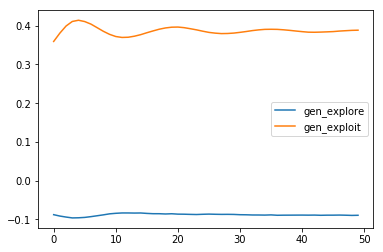

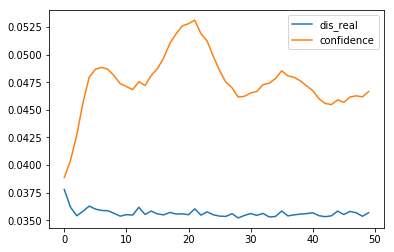

Generation 86  fitness : -51.60743056184109
#################################
Measured population fitness : 3s
population fitness : [-116.00026237 -112.82418496  -79.30142508 -116.71944901 -120.09755773
 -104.95463008 -120.11723449 -105.6496742  -115.87337268  -83.29361166]
mean fit : -107.48314022506197
tensor([-0.5264, -0.0148, -0.5599, -0.5010, -0.4963, -0.4132, -0.4920, -0.4956,
        -0.4719, -0.4398, -0.4947, -0.2633, -0.4184, -0.2514, -0.4879, -0.2216,
        -0.4586, -0.6644, -0.3828, -0.5262], device='cuda:0')
tensor([-0.4297, -0.4262, -0.4284, -0.4248, -0.4274, -0.4259, -0.4293, -0.4297,
        -0.4284, -0.4299, -0.4238, -0.4375, -0.4259, -0.4371, -0.4309, -0.4285,
        -0.4347, -0.4252, -0.4335, -0.4265],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


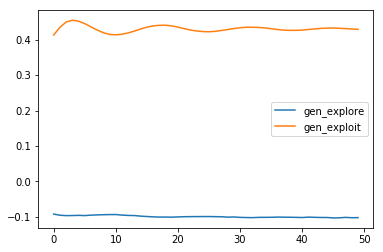

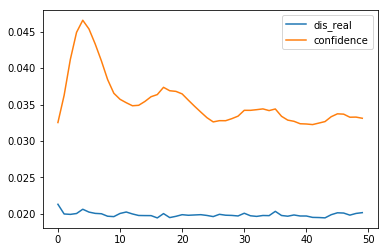

Generation 87  fitness : -79.30142507570604
#################################
Measured population fitness : 1s
population fitness : [-116.36205363 -116.57789971 -123.55710552 -117.28673038 -110.62426033
 -119.72618647 -114.42688333 -104.33099539  -62.2603763  -121.03428393]
mean fit : -110.6186774991256
tensor([-0.4033, -0.4905, -0.5001, -0.4080, -0.5281, -0.4503, -0.2164, -0.5469,
        -0.4932, -0.5211, -0.4668, -0.5183, -0.4958, -0.0892, -0.4132, -0.4895,
        -0.5212, -0.4948, -0.4787, -0.2462], device='cuda:0')
tensor([-0.4340, -0.4372, -0.4417, -0.4376, -0.4395, -0.4367, -0.4364, -0.4374,
        -0.4442, -0.4328, -0.4384, -0.4373, -0.4408, -0.4374, -0.4373, -0.4371,
        -0.4329, -0.4406, -0.4445, -0.4358],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 11s
Evolved : 0s


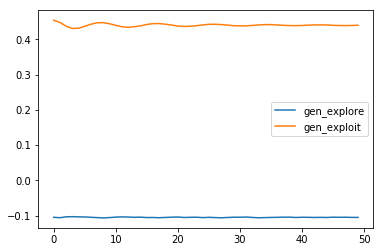

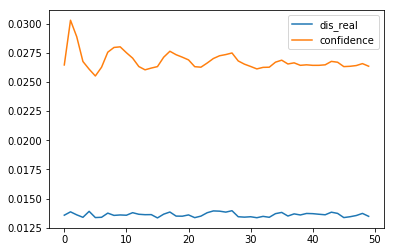

Generation 88  fitness : -62.26037630200031
#################################
Measured population fitness : 3s
population fitness : [-123.53048389 -122.61351135 -119.18509598 -104.24861696 -125.01215356
  -78.00125624 -109.32836574 -118.89711367 -107.38261266  -45.98251643]
mean fit : -105.41817265001923


In [ ]:
population_size = 10
max_seq_length = population_size
max_population = population_size
max_population_batch = 2
out_size = population_size
n_generations = 300

#randomly inititialise starting population
population = []

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)


print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
all_fitnesses = []
gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0001,betas=(0.9,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    #if len(all_fitnesses) > 5:
    #    all_fitnesses.pop(0)
        
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    #fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    fitness_batch_normed = (fitness_batch-np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    #fitness_batch_normed = (fitness_batch-np.min(all_fitnesses))/np.sum(all_fitnesses)
    #Train GAN
    start_time = time.time()
    if i == 0:
        n_epochs = 50
    else:
        n_epochs = 50
    gen_explore_all,gen_exploit_all, dis_loss ,a_gen_all,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              max_seq_length,batch_size =fitness_batch.size,n_epochs = n_epochs)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0#.1
    mutation_rate = 0#.1
    mutation_rate = np.random.choice([0.1, 0], fitness_batch.shape,p=[mutation_rate,1-mutation_rate])
    
    all_r = 0.6
    all_r = np.random.choice([1, 0], p_fitness_.shape,p=[all_r,1-all_r])
    al_lr = all_r * np.abs(np.random.normal(scale = 1,size = p_fitness_.shape))*all_a
   # al_lr = np.array([0]*p_fitness_.size)
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale,al_lr)
    gen.hidden = None
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    #plt.plot(a_gen_all,label='a')
    #plt.legend()
    #plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
#env = gym.make(envs[-2]).unwrapped

p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)


In [ ]:
scale = scale,size = creature.shapefitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 50000)
print(fitness)

In [ ]:
yeet = torch.rand([2,3,2])
print(yeet)
y = torch.rand([2,3,2])
y = torch.argmax(y,-1).type('torch.LongTensor').unsqueeze(-1)

print(y.view(-1).shape)
print(y)

#for i,nae in enumerate(yeet):
#    for j,at in enumerate(nae):
#        new_yeet[i,j] = yeet[i,j][y[i,j]]
        
print(torch.gather(yeet,-1,y))